In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import urllib
N_up = 3
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

import datetime
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import seed

import os
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import math
from numpy.random import uniform, binomial, normal


import torch
import torch.utils.data
import torch.utils.data as data
from torch.optim.optimizer import Optimizer
from torch.autograd import Variable
from torch.nn.functional import softplus
from torch.distributions import kl_divergence
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from torch.distributions import kl_divergence
import torch.backends.cudnn as cudnn
from torch.distributions.normal import Normal
import torch.utils.data
from torchvision.utils import make_grid, save_image
from torch.nn import Module
from torchvision import datasets, transforms







In [3]:
from __future__ import division
from __future__ import print_function
import torch
from torch.autograd import Variable
import sys
import os
import torch.nn as nn
try:
    import cPickle as pickle
except:
    import pickle

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

import torch.nn as nn

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']


def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes) - 1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size


def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]


def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out


def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


import torch.utils.data as data
import numpy as np


class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)


# ----------------------------------------------------------------------------------------------------------------------
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % (self.lr, epoch))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch


def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


class StrToBytes:
    def __init__(self, fileobj):
        self.fileobj = fileobj
    def read(self, size):
        return self.fileobj.read(size).encode()
    def readline(self, size=-1):
        return self.fileobj.readline(size).encode()


def load_object(filename):
    with open(filename, 'rb') as input:
        try:
            return pickle.load(input)
        except Exception as e:
            try:
                print(e)
                return pickle.load(input, encoding="latin1")
            except Exception as a:
                print(a)
                return pickle.load(input, encoding='bytes')
            

def array_to_bin_np(array, ncats):
    array = np.array(array)
    bin_vec = np.zeros(ncats)
    bin_vec[array] = 1
    return bin_vec.astype(bool)


def MNIST_mean_std_norm(x):
    mean = 0.1307
    std = 0.3081
    x = x - mean
    x = x / std
    return x

def complete_logit_norm_vec(vec):
    last_term = 1 - vec.sum(dim=1, keepdim=True)
    cvec = torch.cat((vec, last_term), dim=1)
    return cvec


class Ln_distance(nn.Module):
    """If dims is None Compute across all dimensions except first"""
    def __init__(self, n, dim=None):
        super(Ln_distance, self).__init__()
        self.n = n
        self.dim = dim

    def forward(self, x, y):
        d = x - y
        if self.dim is None:
            self.dim = list(range(1, len(d.shape)))
        return torch.abs(d).pow(self.n).sum(dim=self.dim).pow(1./float(self.n))


def smooth_median(X, dim=0):
    """Just gets numpy behaviour instead of torch default
    dim is dimension to be reduced, across which median is taken"""
    yt = X.clone()
    ymax = yt.max(dim=dim, keepdim=True)[0] # maybe this is wrong  and dont need keepdim
    yt_exp = torch.cat((yt, ymax), dim=dim)
    smooth_median = (yt_exp.median(dim=dim)[0] + yt.median(dim=dim)[0]) / 2.
    return smooth_median


class l1_MAD(nn.Module):
    """Intuition behind this metric -> allows variability only where the dataset has variability
    Otherwise it penalises discrepancy heavily. Might not make much sense if data is already normalised to
    unit std. Might also not make sense if we want to detect outlier values in specific features."""
    def __init__(self, trainset_data, median_dim=0, dim=None):
        """Median dim are those across whcih to normalise (not features)
        dim is dimension to sum (features)"""
        super(l1_MAD, self).__init__()
        self.dim = dim
        feature_median = smooth_median(trainset_data, dim=median_dim).unsqueeze(dim=median_dim)
        self.MAD = smooth_median((trainset_data - feature_median).abs(), dim=median_dim).unsqueeze(dim=median_dim)
        self.MAD = self.MAD.clamp(min=1e-4)

    def forward(self, x, y):
        d = x - y
        if self.dim is None:
            self.dim = list(range(1, len(d.shape)))
        return (torch.abs(d) / self.MAD).sum(dim=self.dim)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
cuda = torch.cuda.is_available()

# Setup for Tabular

We generate artificial datasets with train/test sets matching the original ones

In [5]:
names = ['wine', 'default_credit', 'compas', 'lsat']

art_Npoints = [1438+160, 27000+3000, 5554+618, 17432+4358]
art_Ntrain = [1438, 27000, 5554, 17432]

test_dims = [[11], [29, 30], [17, 18], [12]] 
test_dims_rel = [-1, [-2, -1], [-2, -1], -1] 

bnn_widths = [200, 200, 200, 200]
bnn_depths = [2, 2, 2, 2]

vae_widths = [300, 300, 300, 300] # [200, 200, 200, 200]
vae_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vae_latent_dims = [6, 8, 4, 4]

vaeac_widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
vaeac_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vaeac_latent_dims = [6, 8, 4, 4]
vaeac_under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
vaeac_under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

# For automatic explainer generation

regression_bools = [True, False, False, True]
gauss_cat_vae_bools = [False, True, True, True]
flat_vae_bools = [False, False, False, False]
flat_vaeac_bools = [False, True, False, False]

var_names = {}
var_names_flat = {}

var_names['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
var_names_flat['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

var_names['default_credit'] = ['Given credit', 'Gender', 'Education', 'Marital status', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']
var_names_flat['default_credit'] = ['Given credit', 'Gender M', 'Gender F', 'Education grad', 'Education under', 'Education HS', 'Education Other',
                 'Marital status M', 'Marital status S', 'Marital status Other', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']

var_names['compas'] = ["age_cat", "race", "sex", "c_charge_degree", 'is_recid', 'priors_count', 'time_served']
var_names_flat['compas'] = ['25 - 45', 'Greater than 45', 'Less than 25', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'Female', 'Male', 'Felony', 'misdemeanour', 'not_recid', 'is_recid', 'priors_count', 'time_served']

var_names['lsat'] = ['LSAT', 'UGPA', 'race', 'sex']
var_names_flat['lsat'] = ['LSAT', 'UGPA', 'amerind', 'mexican', 'other', 'black', 'asian', 'puerto', 'hisp', 'white', 'female', 'male']



In [6]:
dname = 'compas'
d_idx = names.index(dname)

In [7]:
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable

    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        print(X_dims.shape, x_means.shape)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims

def join_compas_targets(x_train, x_test, y_train, y_test, X_dims):
    # output from get method is onehot so we need to flatten and append 2
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    input_dim_vec = np.append(input_dim_vec, 2)
    enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
    enc.fit(y_train.reshape(-1, 1))

    vals_train = np.array(enc.transform(y_train.reshape(-1, 1)).todense()).astype(np.float32)
    vals_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()).astype(np.float32)

    x_train = np.concatenate([x_train, vals_train], axis=1)
    x_test = np.concatenate([x_test, vals_test], axis=1)
    return x_train, x_test, input_dim_vec

def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

#"""
def input_dim_vec_to_X_dims(input_dim_vec):
    # This is for our cat_Gauss VAE model
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)
#"""

In [8]:
#from src.UCI_loader import load_UCI, unnormalise_cat_vars
#from src.compas_loader import get_my_COMPAS, X_dims_to_input_dim_vec, join_compas_targets
#from src.LSAT_loader import get_my_LSAT, join_LSAT_targets
#from src.gauss_cat import gauss_cat_to_flat

def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    """
    Converts a feature vector with continous values into a vector with continous and discrete values for those 
    which come from a categorical class.
    """
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x


if dname == 'wine':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=True, save_dir='../../data/')
    xy_train, xy_test, xy_means, xy_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../../data/')
    print(x_train.shape)
    print(xy_train.shape)
    
elif dname == 'default_credit':
    # Note that this dataset is given without flattening
    xy_train, xy_test, xy_means, xy_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../../data/')
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=True, save_dir='../../data/')
    print('Credit', xy_train.shape, xy_test.shape)
    input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1]
    input_dim_vec_xy = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
    
    x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
    x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)
    y_train = unnormalise_cat_vars(y_train, y_means, y_stds, [2])
    y_test = unnormalise_cat_vars(y_test, y_means, y_stds, [2])
    
    xy_train = unnormalise_cat_vars(xy_train, xy_means, xy_stds, input_dim_vec_xy)
    xy_test = unnormalise_cat_vars(xy_test, xy_means, xy_stds, input_dim_vec_xy)
    
    xy_train = gauss_cat_to_flat(torch.Tensor(xy_train), input_dim_vec_xy)
    xy_test = gauss_cat_to_flat(torch.Tensor(xy_test), input_dim_vec_xy)
    print(input_dim_vec_xy)

elif dname == 'compas':
    x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='./notebooks/data/')
    
    xy_train, xy_test, input_dim_vec_xy = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    
    print(x_means.shape)
    xy_means = np.append(x_means, [0, 0])
    xy_stds = np.append(x_stds, [1, 1])
    print(input_dim_vec_xy)
    
elif dname == 'lsat':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, my_data_keys, input_dim_vec = \
    get_my_LSAT(save_dir='../../data/')
    xy_means = np.concatenate([x_means, y_means])
    xy_stds = np.concatenate([x_stds, y_stds])
    xy_train, xy_test, input_dim_vec_xy = join_LSAT_targets(x_train, x_test, y_train, y_test, input_dim_vec)
    print('LSAT', x_train.shape, x_test.shape)
    print(input_dim_vec_xy)



(17,)
[3 6 2 2 2 1 1 2]


## Networks

In [9]:

#"""
class SkipConnection(nn.Module):

    #Skip-connection over the sequence of layers in the constructor.
    #The module passes input data sequentially through these layers
    #and then adds original data to the result.

    def __init__(self, *args):
        super(SkipConnection, self).__init__()
        self.inner_net = nn.Sequential(*args)

    def forward(self, input):
        return input + self.inner_net(input)
#"""
def preact_leaky_MLPBlock(width):
    return SkipConnection(
        nn.LeakyReLU(),
        nn.BatchNorm1d(num_features=width),
        nn.Linear(width, width),
        )



## Fully linear residual path preact models

#Prior net
class MLP_preact_prior_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_prior_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim*2, width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(preact_leaky_MLPBlock(width))
        # output layer
        proposal_layers.extend([nn.LeakyReLU(), nn.BatchNorm1d(num_features=width), nn.Linear(width, latent_dim * 2)])


        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)

#Encoder
class MLP_preact_recognition_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_recognition_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim, width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(preact_leaky_MLPBlock(width))
        # output layer
        proposal_layers.extend([nn.LeakyReLU(), nn.BatchNorm1d(num_features=width), nn.Linear(width, latent_dim * 2)])

        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)

#Decoder
class MLP_preact_generator_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_generator_net, self).__init__()
        # input layer
        generative_layers = [nn.Linear(latent_dim, width)]
        # body
        for i in range(depth-1):
            generative_layers.append(
                # skip-connection from prior network to generative network
                preact_leaky_MLPBlock(width))
        # output layer
        generative_layers.extend([
            nn.LeakyReLU(), nn.BatchNorm1d(num_features=width), nn.Linear(width, input_dim),
        ])
        self.block = nn.Sequential(*generative_layers)

    def forward(self, x):
        return self.block(x)

## BASENET

In [10]:
# Base Network

class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % (self.lr, epoch))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

## Sub network

In [11]:
class VAEAC_gauss_cat(nn.Module):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=True):
        super(VAEAC_gauss_cat, self).__init__()

        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e

        self.latent_dim = latent_dim
        self.recognition_net = MLP_preact_recognition_net(self.input_dim, width, depth, latent_dim)
        self.prior_net = MLP_preact_prior_net(self.input_dim, width, depth, latent_dim)
        if pred_sig:
            raise Exception('Not yet implemented')
        else:
            self.generator_net = MLP_preact_generator_net(self.input_dim, width, depth, latent_dim)
            self.rec_loglike = rms_cat_loglike(self.input_dim_vec, reduction='none')
        self.pred_sig = pred_sig
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4


    @staticmethod
    def apply_mask(x, mask):
        """Positive bits in mask are set to 0 in x (observed)"""
        observed = x.clone()  # torch.tensor(x)
        observed[mask.bool()] = 0
        return observed

    def recognition_encode(self, x):
        """Works with flattened representATION"""
        approx_post_params = self.recognition_net(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def prior_encode(self, x, mask):
        """Works with flattened representATION"""
        x = self.apply_mask(x, mask)
        x = torch.cat([x, mask], 1)
        prior_params = self.prior_net(x)
        prior = normal_parse_params(prior_params, 1e-3)
        return prior

    def decode(self, z_sample):
        rec_params = self.generator_net(z_sample)
        return rec_params

    def reg_cost(self, prior):
        num_objects = prior.mean.shape[0]
        mu = prior.mean.view(num_objects, -1)
        sigma = prior.scale.view(num_objects, -1)
        mu_regularizer = -(mu ** 2).sum(-1) / 2 / (self.sigma_mu ** 2)
        sigma_regularizer = (sigma.log() - sigma).sum(-1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def vlb(self, prior, approx_post, x, rec_params):
        if self.pred_sig:
            raise Exception('Not yet imeplemented')
        else:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        prior_regularization = self.reg_cost(prior).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl + prior_regularization

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                raise Exception('Not yet imeplemented')
            else:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)


class VAEAC_gauss_cat_net(BaseNet):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=1e-3, cuda=True, flatten=True):
        super(VAEAC_gauss_cat_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e
        self.flatten = flatten
        if not self.flatten:
            pass
            # raise Exception('Error calculation not supported without flattening')

        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        self.vlb_scale = 1 / len(self.input_dim_vec)  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAEAC_gauss_cat(self.input_dim_vec, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr)  # torch.optim.Adam

    def fit(self, x, mask):
        self.set_mode_train(train=True)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)
        self.optimizer.zero_grad()

        prior = self.model.prior_encode(x_flat, mask)
        approx_post = self.model.recognition_encode(x_flat)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval(self, x, mask, sample=False):
        self.set_mode_train(train=False)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x_flat, mask)

        approx_post = self.model.recognition_encode(x_flat)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval_iw(self, x, mask, k=50):
        self.set_mode_train(train=False)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)


        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x_flat)

        iw_lb = self.model.iwlb(prior, approx_post, x, k)
        return iw_lb.mean().item()

    def get_prior(self, x, mask, flatten=None):
        self.set_mode_train(train=False)
        if flatten is None:
            flatten = self.flatten
        if flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        return prior

    def get_post(self, x, flatten=None):
        self.set_mode_train(train=False)
        if flatten is None:
            flatten = self.flatten
        if flatten:
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, = to_variable(var=(x,), cuda=self.cuda)
        approx_post = self.model.recognition_encode(x)
        return approx_post

    def inpaint(self, x, mask, Nsample=1, z_mean=False, flatten=False, unflatten=False, cat_probs=False):
        self.set_mode_train(train=False)

        if flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        out = []
        for i in range(Nsample):
            if z_mean:
                z_sample = prior.loc.data
            else:
                z_sample = prior.sample()
            rec_params = self.model.decode(z_sample)
            out.append(rec_params.data)
        out = torch.stack(out, dim=0)

        if self.pred_sig:
            raise Exception('Not yet implemented')
        else:
            dim0 = out.shape[0]
            dim1 = out.shape[1]
            out = out.view(dim0*dim1, -1)
            if unflatten:
                out = flat_to_gauss_cat(out, self.input_dim_vec)
            else:
                out = selective_softmax(out, self.input_dim_vec, grad=False, cat_probs=cat_probs)
            out = out.view(dim0, dim1, -1)
            return out.data

    def regenerate(self, z, grad=False, unflatten=False):
        self.set_mode_train(train=False)
        if unflatten and grad:
            raise Exception('flatten and grad options are not compatible')
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            raise Exception('Not yet implemented')
        else:
            if unflatten:
                out = flat_to_gauss_cat(out, self.input_dim_vec)
            else:
                out = selective_softmax(out, self.input_dim_vec, grad=grad)
            return out.data

## VAEAC gauss

In [12]:
class VAE_gauss(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True):
        super(VAE_gauss, self).__init__()

        self.encoder = MLP_preact_recognition_net(input_dim, width, depth, latent_dim)
        if pred_sig:
            self.decoder = MLP_preact_generator_net(2*input_dim, width, depth, latent_dim)
            self.rec_loglike = GaussianLoglike(min_sigma=1e-2)
        else:
            self.decoder = MLP_preact_generator_net(input_dim, width, depth, latent_dim)
            self.m_rec_loglike = MSELoss(reduction='none')
        self.pred_sig = pred_sig

    def encode(self, x):
        approx_post_params = self.encoder(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def decode(self, z_sample):
        rec_params = self.decoder(z_sample)
        return rec_params

    def vlb(self, prior, approx_post, x, rec_params):
        if self.pred_sig:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        else:
            rec = -self.m_rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
            else:
                rec_loglike = -self.m_rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)


class VAE_gauss_net(BaseNet):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True, lr=1e-3, cuda=True):
        super(VAE_gauss_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        if self.cuda:
            self.prior = self.prior = Normal(loc=torch.zeros(latent_dim).cuda(), scale=torch.ones(latent_dim).cuda())
        else:
            self.prior = Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim))
        self.vlb_scale = 1 / input_dim  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAE_gauss(self.input_dim, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr)

    def fit(self, x):
        self.set_mode_train(train=True)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        self.optimizer.zero_grad()

        approx_post = self.model.encode(x)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(self.prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        return vlb.mean().item(), rec_params

    def eval(self, x, sample=False):
        self.set_mode_train(train=False)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        approx_post = self.model.encode(x)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(self.prior, approx_post, x, rec_params)

        return vlb.mean().item(), rec_params

    def eval_iw(self, x, k=50):
        self.set_mode_train(train=False)
        x,  = to_variable(var=(x, ), cuda=self.cuda)

        approx_post = self.model.recognition_encode(x)

        iw_lb = self.model.iwlb(self.prior, approx_post, x, k)
        return iw_lb.mean().item()

    def recongnition(self, x, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)
        approx_post = self.model.encode(x)
        return approx_post

    def regenerate(self, z, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            return normal_parse_params(out, 1e-2)
        else:
            return out

## Under VAEAC

In [13]:
class under_VAEAC(BaseNet):
    def __init__(self, base_VAE, width, depth, latent_dim, lr=1e-3, cuda=True):
        super(under_VAEAC, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.base_VAEAC = base_VAE
        self.pred_sig = False

        self.cuda = cuda

        self.input_dim = self.base_VAEAC.latent_dim
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        if self.cuda:
            self.prior = self.prior = Normal(loc=torch.zeros(latent_dim).cuda(), scale=torch.ones(latent_dim).cuda())
        else:
            self.prior = Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim))
        self.vlb_scale = 1 / self.input_dim  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAE_gauss(self.input_dim, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def fit(self, x):
        self.set_mode_train(train=True)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        self.optimizer.zero_grad()

        z_sample = self.base_VAEAC.recognition_encode(x).sample()
        approx_post = self.model.encode(z_sample)
        u_sample = approx_post.rsample()
        rec_params = self.model.decode(u_sample)

        vlb = self.model.vlb(self.prior, approx_post, z_sample, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        return vlb.mean().item(), rec_params

    def eval(self, x):
        self.set_mode_train(train=False)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        z_sample = self.base_VAEAC.recognition_encode(x).sample()
        approx_post = self.model.encode(z_sample)
        u_sample = approx_post.rsample()
        rec_params = self.model.decode(u_sample)

        vlb = self.model.vlb(self.prior, approx_post, z_sample, rec_params)

        return vlb.mean().item(), rec_params

    def eval_iw(self, x, k=50):
        self.set_mode_train(train=False)
        x,  = to_variable(var=(x, ), cuda=self.cuda)
        z_sample = self.base_VAEAC.recognition_encode(x).sample()
        approx_post = self.model.recognition_encode(z_sample)

        iw_lb = self.model.iwlb(self.prior, approx_post, z_sample, k)
        return iw_lb.mean().item()

    def recongnition(self, x, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)
        approx_post = self.model.encode(x)
        return approx_post

    def regenerate(self, z, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        return out.data

    def u_recongnition(self, x, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)

        z = self.base_VAEAC.recognition_encode(x).loc
        approx_post = self.model.encode(z)
        return approx_post

    def u_mask_recongnition(self, x, mask, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
            mask, = to_variable(var=(mask, ), cuda=self.cuda)
        else:
            x, mask = to_variable(var=(x, mask), cuda=self.cuda)

        z = self.base_VAEAC.prior_encode(x, mask).loc
        approx_post = self.model.encode(z)
        return approx_post

    def u_regenerate(self, u, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not u.requires_grad:
                u.requires_grad = True
        else:
            u, = to_variable(var=(u,), volatile=True, cuda=self.cuda)

        z = self.model.decode(u)
        out = self.base_VAEAC.decode(z)
        if self.base_VAEAC.pred_sig:
            return normal_parse_params(out, 1e-2)
        else:
            return out.data

## RMS cat loglike

In [14]:
class rms_cat_loglike(nn.Module):

    def __init__(self, input_dim_vec, reduction='none'):
        super(rms_cat_loglike, self).__init__()
        self.reduction = reduction
        self.input_dim_vec = input_dim_vec
        self.mse = MSELoss(reduction='none')  # takes(input, target)
        self.ce = CrossEntropyLoss(reduction='none')

    def forward(self, x, y):

        log_prob_vec = []
        cum_dims = 0
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(-self.mse(x[:, cum_dims], y[:, idx]).unsqueeze(1))
                cum_dims += 1

            elif dims > 1:
                if x.shape[1] == y.shape[1]:
                    raise Exception('Input and target seem to be in flat format. Need integer cat targets.')
                                
                if y.is_cuda:
                    tget = y[:, idx].type(torch.cuda.LongTensor)
                else:
                    tget = y[:, idx].type(torch.LongTensor)

                log_prob_vec.append(-self.ce(x[:, cum_dims:cum_dims + dims], tget).unsqueeze(1))
                cum_dims += dims

            else:
                raise ValueError('Error, invalid dimension value')

        log_prob_vec = torch.cat(log_prob_vec, dim=1)

        if self.reduction == 'none':
            return log_prob_vec
        elif self.reduction == 'sum':
            return log_prob_vec.sum()
        elif self.reduction == 'average':
            return log_prob_vec.mean()

## Rectified ADAM

In [15]:
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

## Load GT VAEAC



In [16]:
#from VAEAC.under_net import under_VAEAC
#from VAEAC.fc_gauss_cat import VAEAC_gauss_cat_net
#from VAEAC.fc_gauss import VAEAC_gauss_net

# LOAD VAEAC

if not gauss_cat_vae_bools[d_idx]:
    
    input_dim = xy_train.shape[1]
    width = vaeac_widths[d_idx]
    depth = vaeac_depths[d_idx] # number of hidden layers
    latent_dim = vaeac_latent_dims[d_idx]
    lr = 3e-4 # They have 3e-4, but it should be 1e-4 according to their paper

    VAEAC = VAEAC_gauss_net(input_dim, width, depth, latent_dim, pred_sig=True, lr=lr, cuda=cuda)
    VAEAC.load('../saves/fc_preact_VAEAC_NEW_' + dname + '_models/theta_best.dat')

else:
    # COMPAS DOES THIS ONE
    width = vaeac_widths[d_idx]
    depth = vaeac_depths[d_idx] # number of hidden layers
    latent_dim = vaeac_latent_dims[d_idx]
    lr = 1e-4 # They have 3e-4, but it should be 1e-4 according to their paper
    VAEAC = VAEAC_gauss_cat_net(input_dim_vec_xy, width, depth, latent_dim, pred_sig=False,
                              lr=lr, cuda=cuda, flatten=flat_vaeac_bools[d_idx])
    VAEAC.load('../saves/fc_preact_VAEAC_NEW_' + dname + '_models/theta_best.dat')

# LOAD Under-NET

base_network = VAEAC.model
width = 150
depth = 2
latent_dim = vaeac_under_latent_dims[d_idx] #VAEAC.latent_dim # change to 2 for better generations
lr = 3e-4

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, lr, cuda=cuda)
under_VAEAC_net.load('../saves/fc_VAEAC_NEW_under2_' + dname + '_models/theta_best.dat')



Net:
VAE_gauss_net
    Total params: 0.78M
Reading ../saves/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

  restoring epoch: 656, lr: 0.000100

Net:
VAE_gauss_net
    Total params: 0.05M


C:\Users\mortimer\AppData\Local\Temp/ipykernel_11108/1645514995.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


Reading ../saves/fc_VAEAC_NEW_under2_compas_models/theta_best.dat

  restoring epoch: 317, lr: 0.000100


317

## Sample artificial datasets

In [49]:
from __future__ import division
from numpy.random import normal
import torch
import torch.nn.functional as F

#"""
def sample_artificial_dataset(under_VAEAC_net, test_dims, Npoints, u_dims, sig=True, bern=False, softmax=False):

    u = torch.Tensor(normal(loc=0.0, scale=1.0, size=(Npoints, u_dims)))
    #print(u.shape)
    #print(sig)
    if sig:
        xy = under_VAEAC_net.u_regenerate(u).sample()
    else:
        xy = under_VAEAC_net.u_regenerate(u).data

    train_dims = list(range(xy.shape[1]))
    
    for e in test_dims:
        train_dims.remove(e)

    x_art = xy[:, train_dims]  # last is test
    if bern:
        x_art = torch.sigmoid(x_art)
    y_art = xy[:, test_dims]  # last is test
    if softmax:
        y_art = F.softmax(y_art, dim=1)

    xy[:, train_dims] = x_art
    xy[:, test_dims] = y_art

    return x_art, y_art, xy
#"""

def sample_artificial_targets_gauss(VAEAC_net, xy, test_dims, N_target_samples, pred_sig, z_mean=False):

    y_mask = torch.zeros_like(xy)
    y_mask[:, test_dims] = 1  # values set to 1 are masked out
    # N_target_samples, Npoints
    y_cond_x = VAEAC_net.inpaint(xy, y_mask, Nsample=N_target_samples, z_mean=z_mean)
    if pred_sig:
        y_cond_x_mu = [i.loc[: ,test_dims] for i in y_cond_x]
        y_cond_x_mu = torch.stack(y_cond_x_mu, dim=0)
        y_cond_x_std = [i.scale[: ,test_dims] for i in y_cond_x]
        y_cond_x_std = torch.stack(y_cond_x_std, dim=0)
    else:
        y_cond_x_mu = y_cond_x[:, :, test_dims]
        y_cond_x_std = torch.ones((y_cond_x.shape[0], y_cond_x.shape[1], len(test_dims)))
    return y_cond_x_mu, y_cond_x_std

# Used for MNIST
"""
def sample_artificial_targets_bern(VAEAC_net, xy, test_dims, N_target_samples, z_mean=False):
    y_mask = torch.zeros_like(xy)
    y_mask[:, test_dims] = 1  # values set to 1 are masked out
    # N_target_samples, Npoints
    xy_cond_x = VAEAC_net.inpaint(xy, y_mask, Nsample=N_target_samples, z_mean=z_mean, logits=True).data

    y_cond_x = xy_cond_x[:, :, test_dims]
    y_cond_x = F.softmax(y_cond_x, dim=2)

    return y_cond_x
"""

def sample_artificial_targets_cat(VAEAC_net, xy, test_dims, N_target_samples, z_mean=False, softmax=False):
    y_mask = torch.zeros_like(xy)
    y_mask[:, test_dims] = 1  # values set to 1 are masked out
    # N_target_samples, Npoints
    xy_cond_x = VAEAC_net.inpaint(xy, y_mask, Nsample=N_target_samples, z_mean=z_mean, cat_probs=True).data

    y_cond_x = xy_cond_x[:, :, test_dims]
    if softmax:
        y_cond_x = F.softmax(y_cond_x, dim=2)

    return y_cond_x

## selective softmax

In [50]:
from __future__ import division
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
import torch.nn.functional as F
#from src.utils import torch_onehot
import torch

def torch_onehot(y, Nclass):
    #print("y: ", y)
    if y.is_cuda:
        y = y.type(torch.cuda.LongTensor)
    else:

        y = y.type(torch.LongTensor)
    #print("zeros :", torch.zeros((y.shape[0], Nclass)).type(y.type()))
    y_onehot = torch.zeros((y.shape[0], Nclass)).type(y.type())
    # In your for loop
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    #print("onehot: ", y_one_hot)
    return y_onehot

def selective_softmax(x, input_dim_vec, num_features, run, grad=False, cat_probs=False, prob_sample=False, eps=1e-20):
    """Applies softmax operation to specified dimensions. Gradient estimator is optional.
    cat_probs returns probability vectors over categorical variables instead of maxing
    if cat_probs is activated with prob sample, a one-hot vector will be sampled (reparametrisable)"""
    output = torch.zeros_like(x)
    
    cum_dims = 0
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output[:, cum_dims] = x[:, cum_dims]
            if prob_sample:  # this assumes an rms loss when training
                noise = x.new_zeros(x.shape[0]).normal_(mean=0, std=1)
                #print("noise shape: ", noise.shape)
                output[:, cum_dims] = output[:, cum_dims] + noise
                #print("output after noise shape: ", output[:, cum_dims].shape)
                num_features[run, cum_dims] += torch.mean(output[:, cum_dims]).item()
                #print("Average cont: ", torch.mean(output[:, cum_dims]).item())
                #print("-------")
            cum_dims += 1
        elif dim > 1:
            if not cat_probs:
                if not grad:
                    y = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_vec = torch_onehot(y, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = y_vec
                # COMPAS
                else:
                    x_cat = x[:, cum_dims:cum_dims + dim]
                    probs = F.softmax(x_cat, dim=1)
                    y_hard = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_oh = torch_onehot(y_hard, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = (y_oh - probs).detach() + probs
            else:
                
                x_cat = x[:, cum_dims:cum_dims + dim]
                
                #print("x_Cat : ", x_cat)
                
                probs = F.softmax(x_cat, dim=1)

                #print("probs : ", probs.shape)
                
                if prob_sample:  # we are going to use gumbel trick here
                    log_probs = torch.log(probs)
                    #print("log_probs: ", log_probs)
                    u = log_probs.new(log_probs.shape).uniform_(0, 1)
                    #print("u: ", u.shape)
                    
                    #print("new: ", type(log_probs.new(log_probs.shape)))
                    #print("u: ", u)
                    g = -torch.log(-torch.log(u + eps) + eps)
                    
                    #print("log_probs: ", log_probs)
                    #print("g: ", g)
                    
                    #print(log_probs+g)
                    
                    cat_samples = (log_probs + g).max(dim=1)[1]
                    #print("cat_samples: ", cat_samples)
                    hard_samples = torch_onehot(cat_samples, dim).type(x.type())
                    
                    for i in range(dim):
                        num_features[run, cum_dims+i] += len(np.where(hard_samples.cpu()[:, i] == 1)[0])
                        #print(str(i) + ": ", len(np.where(hard_samples.cpu()[:, i] == 1)[0]))
                    #print("0: ", len(np.where(hard_samples.cpu()[:, 0] == 1)[0]))
                    #print("1: ", len(np.where(hard_samples.cpu()[:, 1] == 1)[0]))
                    #print("2: ", len(np.where(hard_samples.cpu()[:, 2] == 1)[0]))
                    #print("--------")
                    
                    #print("cat samples: ", cat_samples)
                    #print("hard samples: ", hard_samples)
                    #print("hard samples size: ", hard_samples.shape)
                    output[:, cum_dims:cum_dims + dim] = hard_samples
                else:
                    output[:, cum_dims:cum_dims + dim] = probs


            cum_dims += dim
        else:
            raise ValueError('Error, invalid dimension value')
    #print("output: ", output)        
    #print("output size ", output.shape)
    return output

# Generate art data

In [54]:
#from src.gauss_cat import selective_softmax
#from interpret.generate_data import sample_artificial_dataset, sample_artificial_targets_gauss, sample_artificial_targets_cat


num_runs = 1000

num_features_x = np.zeros((num_runs, sum(input_dim_vec)))
num_features_xy = np.zeros((num_runs, sum(input_dim_vec_xy)))
num_features_y = np.zeros((num_runs, sum(input_dim_vec_xy) - sum(input_dim_vec)))

for run in range(num_runs):

    Npoints = art_Npoints[d_idx]
    Ntrain = art_Ntrain[d_idx]

    x_art, y_art, xy_art = sample_artificial_dataset(under_VAEAC_net, test_dims[d_idx], Npoints,
                                    u_dims=vaeac_under_latent_dims[d_idx],
                                                     sig=((not gauss_cat_vae_bools[d_idx]) and regression_bools[d_idx]),
                                                     softmax=False)

    if gauss_cat_vae_bools[d_idx]:
        x_art = selective_softmax(x_art, input_dim_vec, num_features_x, run, grad=False, cat_probs=True, prob_sample=True) # makes output probabilistic and draws sample
        #print("===================================")
        xy_art = selective_softmax(xy_art, input_dim_vec_xy, num_features_xy, run, grad=False, cat_probs=True, prob_sample=True)

    y_art_gen = y_art

    conditional_targets = False 

    if not regression_bools[d_idx]:
        if conditional_targets:
            y_art = sample_artificial_targets_cat(VAEAC, xy_art, test_dims[d_idx], N_target_samples=500,
                                                  z_mean=False, softmax=False).data
            y_art = y_art.mean(dim=0)

        else:
            y_art = selective_softmax(y_art, [2], num_features_y, run, grad=False, cat_probs=True, prob_sample=True)

            #print("y art ", y_art)
        _, y_art_BNN = y_art.max(dim=1)  # get integer label
        #print("y art BNN ", y_art_BNN)

    else:
        if conditional_targets:
            y_art, stds = sample_artificial_targets_gauss(VAEAC, xy_art, test_dims[d_idx], N_target_samples=500,
                                            pred_sig=((not gauss_cat_vae_bools[d_idx]) and regression_bools[d_idx]),
                                            z_mean=False)
            y_art = y_art.mean(dim=0)

        y_art_BNN = y_art
        if len(y_art_BNN.shape) == 1:
            y_art_BNN = y_art_BNN.unsqueeze(1)


    ###################################################################################################

    # xy_art_train = xy_art[:Ntrain, :].cpu().numpy()
    # xy_art_test = xy_art[Ntrain:, :].cpu().numpy()

    x_art_train = x_art[:Ntrain, :].cpu().numpy()
    x_art_test = x_art[Ntrain:, :].cpu().numpy()

    y_art_train = y_art[:Ntrain, :].cpu().numpy()
    y_art_test = y_art[Ntrain:, :].cpu().numpy()

    if regression_bools[d_idx]:
        y_art_BNN_train = y_art_BNN[:Ntrain, :].cpu().numpy()
        y_art_BNN_test = y_art_BNN[Ntrain:, :].cpu().numpy()

    else:
        y_art_BNN_train = y_art_BNN[:Ntrain].cpu().numpy()
        y_art_BNN_test = y_art_BNN[Ntrain:].cpu().numpy()

    #print('------------')
    #print(x_art_train.shape)
    #print(y_art_train.shape)
    #print(x_art_test.shape)
    #print(y_art_test.shape)

    #print("x_art_train : ", x_art_train)
    #print("y_art_train : ", y_art_train)
    #print("x_art_test : ", x_art_test)
    #print("y_art_test : ", y_art_test)

    art_trainset_BNN = Datafeed(x_art_train, y_art_BNN_train, transform=None)
    art_valset_BNN = Datafeed(x_art_test, y_art_BNN_test, transform=None)

    art_trainset = Datafeed(x_art_train, y_art_train, transform=None)
    art_valset = Datafeed(x_art_test, y_art_test, transform=None)


    
print("==========")
print(np.mean(num_features_x, axis = 0))
print(np.std(num_features_x, axis = 0))
print("==========")
print(np.mean(num_features_xy, axis = 0))
print(np.std(num_features_xy, axis = 0))
print("==========")
print(np.mean(num_features_y, axis = 0))
print(np.std(num_features_y, axis = 0))

# art_x_trainset = Datafeed(x_art_train, x_art_train, transform=None)
# art_x_valset = Datafeed(x_art_test, x_art_test, transform=None)


[ 3.69275900e+03  1.10965400e+03  1.36958700e+03  3.16888700e+03
  4.82240000e+01  2.03755900e+03  4.93308000e+02  1.52050000e+01
  4.08817000e+02  9.92142000e+02  5.17985800e+03  4.03655900e+03
  2.13544100e+03  3.08148700e+03  3.09051300e+03 -8.51037929e-02
 -6.21463754e-02]
[3.79459473e+01 2.99582423e+01 3.31079814e+01 4.02633112e+01
 6.77346470e+00 3.74792012e+01 2.15417997e+01 3.86768342e+00
 1.87830645e+01 2.83613440e+01 2.83613440e+01 3.51720133e+01
 3.51720133e+01 3.92112972e+01 3.92112972e+01 1.54537846e-02
 1.50264269e-02]
[ 3.69234100e+03  1.10972900e+03  1.36993000e+03  3.17006300e+03
  4.82430000e+01  2.03786500e+03  4.91491000e+02  1.51760000e+01
  4.09162000e+02  9.92686000e+02  5.17931400e+03  4.03761500e+03
  2.13438500e+03  3.08183000e+03  3.09017000e+03 -8.54127773e-02
 -6.11552128e-02  3.45235100e+03  2.71964900e+03]
[3.77735188e+01 2.97694736e+01 3.26516937e+01 4.02207289e+01
 7.00513747e+00 3.75004103e+01 2.15250997e+01 3.93408490e+00
 1.90842803e+01 2.79218088e+0

# Train models on artificial data

We recomend using pretrained models for faster results

In [ ]:
use_pretrained_ART = True

## Train BNN

## A variety of files

In [56]:
print(round(3.4))
print(round(3.6))

3
4


In [13]:
from __future__ import division
import torch
from torchvision import datasets, transforms
from BNN.models import MLP_gauss
from BNN.wrapper import BNN_gauss, BNN_cat, MLP
from BNN.train import train_BNN_regression, train_BNN_classification
import numpy as np

if regression_bools[names.index(dname)]:
    
    y_means = torch.Tensor(y_means)
    y_stds = torch.Tensor(y_stds)
    
    input_dim = x_art_train.shape[1]
    width = bnn_widths[names.index(dname)]
    depth = bnn_depths[names.index(dname)]
    output_dim = y_art_train.shape[1]
    model = MLP_gauss(input_dim, width, depth, output_dim, flatten_image=False)

    N_train = x_art_train.shape[0]
    lr = 1e-2
    cuda = torch.cuda.is_available()
    art_BNN = BNN_gauss(model, N_train, lr=lr, cuda=cuda)
    
    batch_size = 512
    nb_epochs = 2400 # We can do less iterations as this method has faster convergence

    ## weight saving parameters #######
    burn_in = 120 # this is in epochs 
    sim_steps = 20 # We want less correlated samples -> despite having per minibatch noise we see correlations
    N_saves = 100
    resample_its = 10
    resample_prior_its = 50 # 45 can be choosen to better control overfitting 
    re_burn = 1e7
    nb_its_dev = 10

    save_dir = '../../saves/fc_BNN_NEW_ART_' + dname

    if not use_pretrained_ART:
        cost_train, cost_dev, rms_dev, ll_dev = train_BNN_regression(art_BNN, save_dir, batch_size, nb_epochs, art_trainset_BNN, art_valset_BNN, cuda,
                                         burn_in, sim_steps, N_saves, resample_its, resample_prior_its,
                                         re_burn, flat_ims=False, nb_its_dev=nb_its_dev, y_mu=y_means, y_std=y_stds)
    
else:
    N_train = x_art_train.shape[0]
    input_dim = x_art_train.shape[1]
    width = bnn_widths[names.index(dname)]
    depth = bnn_depths[names.index(dname)]
    output_dim = 2
    model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

    lr = 1e-2
    cuda = torch.cuda.is_available()
    art_BNN = BNN_cat(model, N_train, lr=lr, cuda=cuda)
    
    batch_size = 512#
    nb_epochs = 2400 # We can do less iterations as this method has faster convergence
    
    burn_in = 120 # this is in epochs 
    sim_steps = 20 # We want less correlated samples -> despite having per minibatch noise we see correlations
    N_saves = 100
    resample_its = 10
    resample_prior_its = 50
    re_burn = 1e7
    nb_its_dev = 10
    
    
    save_dir = '../../saves/fc_BNN_NEW_ART_' + dname

    if not use_pretrained_ART:
        cost_train, cost_dev, err_train, err_dev = train_BNN_classification(art_BNN, save_dir, batch_size,
                                 nb_epochs, art_trainset_BNN, art_valset_BNN, cuda,
                                 burn_in, sim_steps, N_saves, resample_its, resample_prior_its,
                                 re_burn, flat_ims=False, nb_its_dev=nb_its_dev)


art_BNN.load_weights(save_dir + '_models/state_dicts.pkl')




Net:
BNN categorical output
    Total params: 0.05M


## Train VAE



In [14]:
import torch
from torchvision import datasets, transforms
from VAE.fc_gauss import VAE_gauss_net
from VAE.fc_gauss_cat import VAE_gauss_cat_net
from VAE.train import train_VAE
from src.utils import Datafeed

width = vae_widths[names.index(dname)]
depth = vae_depths[names.index(dname)] # number of hidden layers
latent_dim = vae_latent_dims[names.index(dname)]

if not gauss_cat_vae_bools[names.index(dname)]:
    input_dim = x_art_train.shape[1]
    lr = 1e-4
    cuda = torch.cuda.is_available()
    VAE_art = VAE_gauss_net(input_dim, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda)
    
    batch_size = 128
    nb_epochs = 2500
    early_stop = 200

    save_dir = '../../saves/fc_preact_VAE_NEW(300)_ART_' + dname
    
    if not use_pretrained_ART:
        vlb_train, vlb_dev = train_VAE(VAE_art, save_dir, batch_size, nb_epochs, art_trainset, art_valset,
                                       cuda=cuda, flat_ims=False, train_plot=False, early_stop=early_stop)
    
else:
    cuda = torch.cuda.is_available()
    lr = 1e-4
    VAE_art = VAE_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False,
                            lr=lr, cuda=cuda, flatten=flat_vae_bools[names.index(dname)])  
    
    batch_size = 128
    nb_epochs = 2500
    lr = 1e-4
    early_stop = 200

    save_dir = '../../saves/fc_preact_VAE_NEW(300)_ART_' + dname
    
    if not use_pretrained_ART:
        vlb_train, vlb_dev = train_VAE(VAE_art, save_dir, batch_size, nb_epochs, art_trainset, art_valset,
                                       cuda=cuda, flat_ims=False, train_plot=False, early_stop=early_stop)

VAE_art.load(save_dir + '_models/theta_best.dat')



Net:
VAE_gauss_net
    Total params: 0.39M
Reading ../saves/fc_preact_VAE_NEW(300)_ART_default_credit_models/theta_best.dat

  restoring epoch: 723, lr: 0.000100


723

## Train VAEAC noclass 

In [31]:
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

# (used in sub network)
def normal_parse_params(params, min_sigma=1e-3):
    """
    Take a Tensor (e. g. neural network output) and return
    torch.distributions.Normal distribution.
    This Normal distribution is component-wise independent,
    and its dimensionality depends on the input shape.
    First half of channels is mean of the distribution,
    the softplus of the second half is std (sigma), so there is
    no restrictions on the input tensor.
    min_sigma is the minimal value of sigma. I. e. if the above
    softplus is less than min_sigma, then sigma is clipped
    from below with value min_sigma. This regularization
    is required for the numerical stability and may be considered
    as a neural network architecture choice without any change
    to the probabilistic model.
    """
    n = params.shape[0]
    d = params.shape[1]
    mu = params[:, :d // 2]
    sigma_params = params[:, d // 2:]
    sigma = softplus(sigma_params)
    sigma = sigma.clamp(min=min_sigma)
    distr = Normal(mu, sigma)
    return distr

## (used in the next function)
def torch_onehot(y, Nclass):
    if y.is_cuda:
        y = y.type(torch.cuda.LongTensor)
    else:
        y = y.type(torch.LongTensor)
    y_onehot = torch.zeros((y.shape[0], Nclass)).type(y.type())
    # In your for loop
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    return y_onehot

## (used in the fit of the main network)
def gauss_cat_to_flat(x, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(x[:, idx].unsqueeze(1))
        elif dim > 1:
            oh_vec = torch_onehot(x[:, idx], dim).type(x.type())
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return torch.cat(output, dim=1)

## (also used in the fit of the main network)
def flat_to_gauss_cat(x, input_dim_vec):
    output = []
    cum_dims = 0
    for idx, dims in enumerate(input_dim_vec):
        if dims == 1:
            output.append(x[:, cum_dims].unsqueeze(1))
            cum_dims += 1

        elif dims > 1:
            output.append(x[:, cum_dims:cum_dims + dims].max(dim=1)[1].type(x.type()).unsqueeze(1))
            cum_dims += dims

        else:
            raise ValueError('Error, invalid dimension value')

    return torch.cat(output, dim=1)

def gauss_cat_to_flat_mask(x, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(x[:, idx].unsqueeze(1))
        elif dim > 1:
            oh_vec = x.new_ones(x.shape[0], dim) * x[:, idx].unsqueeze(1)
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return torch.cat(output, dim=1)

## (also used in the fit of the main network)
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out


# Datafeed function which does something, seems to just be a class for the data?
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)

In [32]:
class top_masker:
    """
    Returned mask is sampled from component-wise independent Bernoulli
    distribution with probability of component to be unobserved p.
    Such mask induces the type of missingness which is called
    in literature "missing completely at random" (MCAR).
    If some value in batch is missed, it automatically becomes unobserved.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        pp = uniform(low=0.0, high=self.p, size=batch.shape[0])
        pp = np.expand_dims(pp, axis=1)
        pp = np.repeat(pp, batch.shape[1], axis=1)
        nan_mask = torch.isnan(batch).float()  # missed values
#         bernoulli_mask_numpy = np.random.choice(2, size=batch.shape,
#                                                 p=[1 - pp, pp])
        bernoulli_mask_numpy = binomial(1, pp, size=None)
#         print(bernoulli_mask_numpy.shape)
        bernoulli_mask = torch.from_numpy(bernoulli_mask_numpy).float()
        mask = torch.max(bernoulli_mask, nan_mask)  # logical or
        return mask
    
masker = top_masker(p=1)



In [33]:
# Main Network
class VAEAC_gauss_net(BaseNet):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True, lr=1e-3, cuda=True):
        super(VAEAC_gauss_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        self.vlb_scale = 1 / input_dim  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAEAC_gauss(self.input_dim, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr) # torch.optim.Adam

    def fit(self, x, mask):
        self.set_mode_train(train=True)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        self.optimizer.zero_grad()

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval(self, x, mask, sample=False):
        self.set_mode_train(train=False)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)

        approx_post = self.model.recognition_encode(x)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval_iw(self, x, mask, k=50):
        self.set_mode_train(train=False)
        x, mask = to_variable(var=(x, mask), cuda=self.cuda)

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x)

        iw_lb = self.model.iwlb(prior, approx_post, x, k)
        return iw_lb.mean().item()

    def get_prior(self, x, mask):
        self.set_mode_train(train=False)
        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        return prior

    def get_post(self, x):
        self.set_mode_train(train=False)
        x, = to_variable(var=(x,), cuda=self.cuda)
        approx_post = self.model.recognition_encode(x)
        return approx_post

    def inpaint(self, x, mask, Nsample=1, z_mean=False):
        self.set_mode_train(train=False)
        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        out = []
        for i in range(Nsample):
            if z_mean:
                z_sample = prior.loc.data
            else:
                z_sample = prior.sample()
            rec_params = self.model.decode(z_sample)
            out.append(rec_params.data)
        out = torch.stack(out, dim=0)

        if self.pred_sig:
            return [normal_parse_params(out[i], 1e-2) for i in range(Nsample)]
        else:
            return out

    def regenerate(self, z, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            return normal_parse_params(out, 1e-2)
        else:
            return out.data
class VAEAC_gauss_cat(nn.Module):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=True):
        super(VAEAC_gauss_cat, self).__init__()

        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e

        self.latent_dim = latent_dim
        self.recognition_net = MLP_preact_recognition_net(self.input_dim, width, depth, latent_dim)
        self.prior_net = MLP_preact_prior_net(self.input_dim, width, depth, latent_dim)
        if pred_sig:
            raise Exception('Not yet implemented')
        else:
            self.generator_net = MLP_preact_generator_net(self.input_dim, width, depth, latent_dim)
            self.rec_loglike = rms_cat_loglike(self.input_dim_vec, reduction='none')
        self.pred_sig = pred_sig
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4


    @staticmethod
    def apply_mask(x, mask):
        """Positive bits in mask are set to 0 in x (observed)"""
        observed = x.clone()  # torch.tensor(x)
        observed[mask.bool()] = 0
        return observed

    def recognition_encode(self, x):
        """Works with flattened representATION"""
        approx_post_params = self.recognition_net(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def prior_encode(self, x, mask):
        """Works with flattened representATION"""
        x = self.apply_mask(x, mask)
        x = torch.cat([x, mask], 1)
        prior_params = self.prior_net(x)
        prior = normal_parse_params(prior_params, 1e-3)
        return prior

    def decode(self, z_sample):
        rec_params = self.generator_net(z_sample)
        return rec_params

    def reg_cost(self, prior):
        num_objects = prior.mean.shape[0]
        mu = prior.mean.view(num_objects, -1)
        sigma = prior.scale.view(num_objects, -1)
        mu_regularizer = -(mu ** 2).sum(-1) / 2 / (self.sigma_mu ** 2)
        sigma_regularizer = (sigma.log() - sigma).sum(-1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def vlb(self, prior, approx_post, x, rec_params):
        if self.pred_sig:
            raise Exception('Not yet imeplemented')
        else:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        prior_regularization = self.reg_cost(prior).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl + prior_regularization

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                raise Exception('Not yet imeplemented')
            else:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)

In [34]:


class VAEAC_gauss_cat_net(BaseNet):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=1e-3, cuda=True, flatten=True):
        super(VAEAC_gauss_cat_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e
        self.flatten = flatten
        if not self.flatten:
            pass
            # raise Exception('Error calculation not supported without flattening')

        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        self.vlb_scale = 1 / len(self.input_dim_vec)  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAEAC_gauss_cat(self.input_dim_vec, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr)  # torch.optim.Adam

    def fit(self, x, mask):
        self.set_mode_train(train=True)
        
        #print("bef x: ", x.shape)
        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        
        else:
            x_flat = x # X already flattened
            x = flat_to_gauss_cat(x, self.input_dim_vec) # unflattened x (used for loss computation)
        #print("aft x: ", x.shape)
        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)
        self.optimizer.zero_grad()

        prior = self.model.prior_encode(x_flat, mask)
        approx_post = self.model.recognition_encode(x_flat)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval(self, x, mask, sample=False):
        self.set_mode_train(train=False)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x_flat, mask)

        approx_post = self.model.recognition_encode(x_flat)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval_iw(self, x, mask, k=50):
        self.set_mode_train(train=False)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)


        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x_flat)

        iw_lb = self.model.iwlb(prior, approx_post, x, k)
        return iw_lb.mean().item()

    def get_prior(self, x, mask, flatten=None):
        self.set_mode_train(train=False)
        if flatten is None:
            flatten = self.flatten
        if flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        return prior

    def get_post(self, x, flatten=None):
        self.set_mode_train(train=False)
        if flatten is None:
            flatten = self.flatten
        if flatten:
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, = to_variable(var=(x,), cuda=self.cuda)
        approx_post = self.model.recognition_encode(x)
        return approx_post

    def inpaint(self, x, mask, Nsample=1, z_mean=False, flatten=False, unflatten=False, cat_probs=False):
        self.set_mode_train(train=False)

        if flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        out = []
        for i in range(Nsample):
            if z_mean:
                z_sample = prior.loc.data
            else:
                z_sample = prior.sample()
            rec_params = self.model.decode(z_sample)
            out.append(rec_params.data)
        out = torch.stack(out, dim=0)

        if self.pred_sig:
            raise Exception('Not yet implemented')
        else:
            dim0 = out.shape[0]
            dim1 = out.shape[1]
            out = out.view(dim0*dim1, -1)
            if unflatten:
                out = flat_to_gauss_cat(out, self.input_dim_vec)
            else:
                out = selective_softmax(out, self.input_dim_vec, grad=False, cat_probs=cat_probs)
            out = out.view(dim0, dim1, -1)
            return out.data

    def regenerate(self, z, grad=False, unflatten=False):
        self.set_mode_train(train=False)
        if unflatten and grad:
            raise Exception('flatten and grad options are not compatible')
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            raise Exception('Not yet implemented')
        else:
            if unflatten:
                out = flat_to_gauss_cat(out, self.input_dim_vec)
            else:
                out = selective_softmax(out, self.input_dim_vec, grad=grad)
            return out.data

In [35]:
def train_VAEAC(net, masker, name, batch_size, nb_epochs, trainset, valset, cuda,
                flat_ims=False, train_plot=False, Nclass=None, early_stop=None, script_mode=False):

    models_dir = name + '_models'
    results_dir = name + '_results'
    mkdir(models_dir)
    mkdir(results_dir)

    if cuda:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                                  num_workers=0)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                                num_workers=0)

    else:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                                  num_workers=0)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=0)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
    cprint('c', '\nNetwork:')

    epoch = 0

    ## ---------------------------------------------------------------------------------------------------------------------
    # train
    cprint('c', '\nTrain:')

    print('  init cost variables:')
    vlb_train = np.zeros(nb_epochs)
    vlb_dev = np.zeros(nb_epochs)
    iwlb_dev = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0

    nb_its_dev = 1

    tic0 = time.time()
    for i in range(epoch, nb_epochs):
        net.set_mode_train(True)

        tic = time.time()
        nb_samples = 0
        for x, y in trainloader:

            if flat_ims:
                x = x.view(x.shape[0], -1)
            if Nclass is not None:
                y_oh = torch_onehot(y, Nclass).type(x.type())
                x = torch.cat([x, y_oh], 1)

            mask = masker(x)
            cost, _ = net.fit(x, mask)

            vlb_train[i] += cost * len(x)
            nb_samples += len(x)

        vlb_train[i] /= nb_samples

        toc = time.time()

        # ---- print
        print("it %d/%d, vlb %f, " % (i, nb_epochs, vlb_train[i]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))
        net.update_lr(i)

        # ---- dev
        if i % nb_its_dev == 0:
            nb_samples = 0
            for j, (x, y) in enumerate(valloader):

                if flat_ims:
                    x = x.view(x.shape[0], -1)
                if Nclass is not None:
                    y_oh = torch_onehot(y, Nclass).type(x.type())
                    x = torch.cat([x, y_oh], 1)

                mask = masker(x)
                cost, rec_mean = net.eval(x, mask)
                # iwlb = net.eval_iw(x, mask, 25)

                vlb_dev[i] += cost * len(x)
                # iwlb_dev[i] += iwlb
                nb_samples += len(x)

            vlb_dev[i] /= nb_samples
            # iwlb_dev[i] /= nb_samples

            cprint('g', '    vlb %f (%f)\n' % (vlb_dev[i], best_vlb))

            if train_plot:
                xm = net.model.apply_mask(x, mask)
                
                xr = x.cpu()
                rec_inpaint = net.inpaint(xm, mask)
                try:
                    o = rec_mean.cpu()
                    rec_inpaint = rec_inpaint[0].cpu()
                except:
                    o = rec_mean.loc.cpu()
                    rec_inpaint = rec_inpaint[0].loc.cpu()

                if Nclass is not None:
                    xm = xm[:, :-Nclass]
                    rec_inpaint = rec_inpaint[:, :-Nclass]
                    xr = xr[:, :-Nclass]
                    o = o[:, :-Nclass]

                if len(x.shape) == 2:
                    side = int(np.sqrt(xm.shape[1]))
                    xm = xm.view(-1, 1, side, side).data
                    rec_inpaint = rec_inpaint.view(-1, 1, side, side).data
                    xr = xr.view(-1, 1, side, side).data
                    o = o.view(-1, 1, side, side).data

                import matplotlib.pyplot as plt
                plt.figure()
                dd = make_grid(torch.cat([xr[:10], o[:10]]), nrow=10).numpy()
                plt.imshow(np.transpose(dd, (1, 2, 0)), interpolation='nearest')
                plt.title('reconstruct')
                if script_mode:
                    plt.savefig(results_dir + '/rec%d.png' % i)
                else:
                    plt.show()

                import matplotlib.pyplot as plt
                plt.figure()
                dd = make_grid(torch.cat([xm[:10], rec_inpaint[:10]]), nrow=10).numpy()
                plt.imshow(np.transpose(dd, (1, 2, 0)), interpolation='nearest')
                plt.title('inpaint')
                if script_mode:
                    plt.savefig(results_dir + '/inp%d.png' % i)
                else:
                    plt.show()

        if vlb_dev[i] > best_vlb:
            best_vlb = vlb_dev[i]
            best_epoch = i
            net.save(models_dir + '/theta_best.dat')

        if early_stop is not None and (i - best_epoch) > early_stop:
            break


    net.save(models_dir + '/theta_last.dat')
    toc0 = time.time()
    runtime_per_it = (toc0 - tic0) / float(nb_epochs)
    cprint('r', '   average time: %f seconds\n' % runtime_per_it)

    ## ---------------------------------------------------------------------------------------------------------------------
    # results
    cprint('c', '\nRESULTS:')
    nb_parameters = net.get_nb_parameters()
    best_cost_dev = np.max(vlb_dev)
    # best_iw_dev = np.max(iwlb_dev)
    best_cost_train = np.max(vlb_train)

    print('  best_vlb_dev: %f' % best_cost_dev)
    # print('  best_iwlb_dev: %f' % best_iw_dev)
    print('  best_vlb_train: %f' % best_cost_train)
    print('  nb_parameters: %d (%s)\n' % (nb_parameters, humansize(nb_parameters)))

    ## ---------------------------------------------------------------------------------------------------------------------
    # fig cost vs its
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(np.clip(vlb_train, -1000, 1000), 'r')
    plt.plot(np.clip(vlb_dev[::nb_its_dev], -1000, 1000), 'b')
    plt.legend(['cost_train', 'cost_dev'])
    plt.ylabel('vlb')
    plt.xlabel('it')
    plt.grid(True)
    plt.savefig(results_dir+'/train_cost.png')

    # plt.figure()
    # plt.plot(np.clip(iwlb_dev[::nb_its_dev], -1000, 1000), 'b')
    # plt.ylabel('dev iwlb')
    # plt.xlabel('it')
    # plt.grid(True)
    # plt.savefig(results_dir + '/train_iwlb.png')
    if train_plot:
        plt.show()
    return vlb_train, vlb_dev


yas
17 350 3

Net:
VAE_gauss_net
    Total params: 0.78M

Network:

Train:
  init cost variables:


/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_34972/1645514995.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


it 0/2500, vlb -13.596694,    time: 1.894992 seconds

    vlb -10.232374 (-inf)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 1/2500, vlb -11.122999,    time: 1.779434 seconds

    vlb -9.480775 (-10.232374)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 2/2500, vlb -9.624534,    time: 1.872066 seconds

    vlb -8.263696 (-9.480775)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 3/2500, vlb -8.916390,    time: 1.811224 seconds

    vlb -7.721854 (-8.263696)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 4/2500, vlb -8.428131,    time: 1.839307 seconds

    vlb -7.263268 (-7.721854)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 5/2500, vlb -7.969855,    time: 1.682673 seconds

    vlb -6.856191 (-7.263268)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 6/2500, vlb -7.736512,    time: 1.783915 sec

    vlb -3.606625 (-3.510563)

it 50/2500, vlb -4.536225,    time: 2.460678 seconds

    vlb -3.554608 (-3.510563)

it 51/2500, vlb -4.525743,    time: 1.851010 seconds

    vlb -3.577683 (-3.510563)

it 52/2500, vlb -4.520636,    time: 1.614360 seconds

    vlb -3.573346 (-3.510563)

it 53/2500, vlb -4.491408,    time: 1.966392 seconds

    vlb -3.548259 (-3.510563)

it 54/2500, vlb -4.531536,    time: 1.877450 seconds

    vlb -3.489500 (-3.510563)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 55/2500, vlb -4.487152,    time: 1.757450 seconds

    vlb -3.522027 (-3.489500)

it 56/2500, vlb -4.510694,    time: 1.798952 seconds

    vlb -3.519554 (-3.489500)

it 57/2500, vlb -4.509278,    time: 1.796450 seconds

    vlb -3.458913 (-3.489500)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 58/2500, vlb -4.490691,    time: 2.061079 seconds

    vlb -3.438337 (-3.458913)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_mo

    vlb -3.227143 (-3.059811)

it 122/2500, vlb -4.166352,    time: 4.305861 seconds

    vlb -3.170563 (-3.059811)

it 123/2500, vlb -4.159030,    time: 4.361843 seconds

    vlb -3.141641 (-3.059811)

it 124/2500, vlb -4.133276,    time: 4.195064 seconds

    vlb -3.175182 (-3.059811)

it 125/2500, vlb -4.161200,    time: 4.349639 seconds

    vlb -3.234438 (-3.059811)

it 126/2500, vlb -4.172478,    time: 4.132582 seconds

    vlb -3.156522 (-3.059811)

it 127/2500, vlb -4.117348,    time: 3.991835 seconds

    vlb -3.039367 (-3.059811)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 128/2500, vlb -4.135323,    time: 4.269588 seconds

    vlb -3.185289 (-3.039367)

it 129/2500, vlb -4.141573,    time: 4.195898 seconds

    vlb -3.110553 (-3.039367)

it 130/2500, vlb -4.105023,    time: 5.288470 seconds

    vlb -3.074428 (-3.039367)

it 131/2500, vlb -4.096380,    time: 5.175928 seconds

    vlb -3.125357 (-3.039367)

it 132/2500, vlb -4.171719,    tim

    vlb -2.932312 (-2.913778)

it 196/2500, vlb -3.992367,    time: 5.462728 seconds

    vlb -2.997490 (-2.913778)

it 197/2500, vlb -3.906190,    time: 6.215541 seconds

    vlb -2.962891 (-2.913778)

it 198/2500, vlb -3.972777,    time: 6.517654 seconds

    vlb -3.000145 (-2.913778)

it 199/2500, vlb -3.974141,    time: 4.945466 seconds

    vlb -2.943123 (-2.913778)

it 200/2500, vlb -3.956434,    time: 6.961415 seconds

    vlb -2.957777 (-2.913778)

it 201/2500, vlb -3.928885,    time: 5.162994 seconds

    vlb -2.911503 (-2.913778)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 202/2500, vlb -3.908719,    time: 4.855449 seconds

    vlb -3.094535 (-2.911503)

it 203/2500, vlb -3.925805,    time: 4.814196 seconds

    vlb -2.863961 (-2.911503)

Writting ../../saves/fc_preact_VAEAC_NEW_ART_compas_models/theta_best.dat

it 204/2500, vlb -3.952211,    time: 6.068331 seconds

    vlb -3.037364 (-2.863961)

it 205/2500, vlb -3.931639,    time: 6.075303

it 269/2500, vlb -3.774370,    time: 4.313731 seconds

    vlb -2.808057 (-2.707641)

it 270/2500, vlb -3.781649,    time: 4.242928 seconds

    vlb -2.900043 (-2.707641)

it 271/2500, vlb -3.811169,    time: 4.298754 seconds

    vlb -2.895416 (-2.707641)

it 272/2500, vlb -3.808597,    time: 4.184361 seconds

    vlb -2.843344 (-2.707641)

it 273/2500, vlb -3.800883,    time: 4.290861 seconds

    vlb -2.786174 (-2.707641)

it 274/2500, vlb -3.779438,    time: 4.260663 seconds

    vlb -2.803820 (-2.707641)

it 275/2500, vlb -3.857839,    time: 4.319792 seconds

    vlb -2.883637 (-2.707641)

it 276/2500, vlb -3.814730,    time: 4.562381 seconds

    vlb -2.802463 (-2.707641)

it 277/2500, vlb -3.822736,    time: 4.169861 seconds

    vlb -2.755378 (-2.707641)

it 278/2500, vlb -3.788772,    time: 4.220162 seconds

    vlb -2.821108 (-2.707641)

it 279/2500, vlb -3.791070,    time: 4.283905 seconds

    vlb -2.722691 (-2.707641)

it 280/2500, vlb -3.826333,    time: 3.900876 seconds


    vlb -2.754577 (-2.627117)

it 347/2500, vlb -3.772225,    time: 1.449701 seconds

    vlb -2.848305 (-2.627117)

it 348/2500, vlb -3.738670,    time: 1.377156 seconds

    vlb -2.814079 (-2.627117)

it 349/2500, vlb -3.747605,    time: 1.376620 seconds

    vlb -2.867743 (-2.627117)

it 350/2500, vlb -3.721766,    time: 1.383926 seconds

    vlb -2.825372 (-2.627117)

it 351/2500, vlb -3.751415,    time: 1.389705 seconds

    vlb -2.918620 (-2.627117)

it 352/2500, vlb -3.725810,    time: 1.426475 seconds

    vlb -2.757798 (-2.627117)

it 353/2500, vlb -3.765384,    time: 1.389985 seconds

    vlb -2.821256 (-2.627117)

it 354/2500, vlb -3.728066,    time: 1.453711 seconds

    vlb -2.857010 (-2.627117)

it 355/2500, vlb -3.672141,    time: 1.415566 seconds

    vlb -2.777182 (-2.627117)

it 356/2500, vlb -3.748971,    time: 1.382778 seconds

    vlb -2.770347 (-2.627117)

it 357/2500, vlb -3.715332,    time: 1.395604 seconds

    vlb -2.724261 (-2.627117)

it 358/2500, vlb -3.772

it 424/2500, vlb -3.667479,    time: 1.419843 seconds

    vlb -2.820702 (-2.538367)

it 425/2500, vlb -3.729386,    time: 1.403217 seconds

    vlb -2.911631 (-2.538367)

it 426/2500, vlb -3.692841,    time: 1.431683 seconds

    vlb -2.719416 (-2.538367)

it 427/2500, vlb -3.686031,    time: 1.393782 seconds

    vlb -2.704728 (-2.538367)

it 428/2500, vlb -3.667212,    time: 1.458347 seconds

    vlb -2.726680 (-2.538367)

it 429/2500, vlb -3.649472,    time: 1.408741 seconds

    vlb -2.715308 (-2.538367)

it 430/2500, vlb -3.719054,    time: 1.451218 seconds

    vlb -2.790092 (-2.538367)

it 431/2500, vlb -3.631518,    time: 1.375684 seconds

    vlb -2.784169 (-2.538367)

it 432/2500, vlb -3.700624,    time: 1.395203 seconds

    vlb -2.765046 (-2.538367)

it 433/2500, vlb -3.723881,    time: 1.391486 seconds

    vlb -2.817304 (-2.538367)

it 434/2500, vlb -3.663620,    time: 1.379934 seconds

    vlb -2.724827 (-2.538367)

it 435/2500, vlb -3.702599,    time: 1.418710 seconds


it 503/2500, vlb -3.687611,    time: 1.402410 seconds

    vlb -2.852574 (-2.538367)

it 504/2500, vlb -3.653345,    time: 1.448845 seconds

    vlb -2.835942 (-2.538367)

it 505/2500, vlb -3.594852,    time: 1.447188 seconds

    vlb -2.780134 (-2.538367)

it 506/2500, vlb -3.600836,    time: 1.427961 seconds

    vlb -2.796869 (-2.538367)

it 507/2500, vlb -3.677469,    time: 1.388174 seconds

    vlb -2.827680 (-2.538367)

it 508/2500, vlb -3.680285,    time: 1.425890 seconds

    vlb -2.725936 (-2.538367)

it 509/2500, vlb -3.674069,    time: 1.492137 seconds

    vlb -2.611582 (-2.538367)

it 510/2500, vlb -3.614277,    time: 1.400800 seconds

    vlb -2.683766 (-2.538367)

it 511/2500, vlb -3.676285,    time: 1.446442 seconds

    vlb -2.680041 (-2.538367)

it 512/2500, vlb -3.637275,    time: 1.440642 seconds

    vlb -2.771695 (-2.538367)

it 513/2500, vlb -3.653531,    time: 1.436300 seconds

    vlb -2.672367 (-2.538367)

it 514/2500, vlb -3.636326,    time: 1.389681 seconds


it 582/2500, vlb -3.593269,    time: 1.408423 seconds

    vlb -2.748369 (-2.538367)

it 583/2500, vlb -3.612449,    time: 1.416415 seconds

    vlb -2.766098 (-2.538367)

it 584/2500, vlb -3.622120,    time: 1.453017 seconds

    vlb -2.621268 (-2.538367)

it 585/2500, vlb -3.573051,    time: 1.418981 seconds

    vlb -2.804527 (-2.538367)

it 586/2500, vlb -3.623355,    time: 1.429245 seconds

    vlb -2.700812 (-2.538367)

it 587/2500, vlb -3.611752,    time: 1.407071 seconds

    vlb -2.712255 (-2.538367)

it 588/2500, vlb -3.640697,    time: 1.410885 seconds

    vlb -2.771605 (-2.538367)

it 589/2500, vlb -3.622842,    time: 1.430128 seconds

    vlb -2.704469 (-2.538367)

it 590/2500, vlb -3.614670,    time: 1.423902 seconds

    vlb -2.768471 (-2.538367)

it 591/2500, vlb -3.606906,    time: 1.503686 seconds

    vlb -2.751714 (-2.538367)

it 592/2500, vlb -3.585870,    time: 1.397652 seconds

    vlb -2.792661 (-2.538367)

it 593/2500, vlb -3.632306,    time: 1.431985 seconds


418

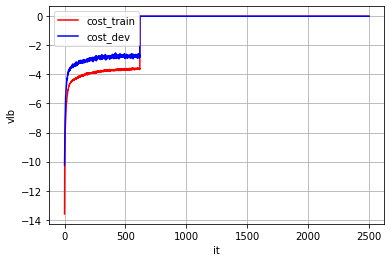

In [41]:
import torch
from torchvision import datasets, transforms
#from VAEAC.fc_gauss import VAEAC_gauss_net
#from VAEAC.fc_gauss_cat import VAEAC_gauss_cat_net
#from VAEAC.train import train_VAEAC
#from src.utils import Datafeed
#from src.masks import top_masker

masker = top_masker(p=1)

use_pretrained_ART = False

width = vaeac_widths[d_idx]
depth = vaeac_depths[d_idx] # number of hidden layers

latent_dim = vaeac_latent_dims[d_idx]
cuda = torch.cuda.is_available()


if not gauss_cat_vae_bools[d_idx]:
    print("yas")
    input_dim = x_art_train.shape[1]
    print(input_dim, width, depth)
    VAEAC_art = VAEAC_gauss_net(input_dim, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda)
    
    batch_size = 128
    nb_epochs = 2500
    lr = 1e-4
    early_stop = 200
    
    save_dir = '../../saves/fc_preact_VAEAC_NEW_ART_' + dname
    
    if not use_pretrained_ART:
        vlb_train, vlb_dev = train_VAEAC(VAEAC_art, masker, save_dir, batch_size, nb_epochs, art_trainset, art_valset, cuda,
                    flat_ims=False, train_plot=False, Nclass=None, early_stop=early_stop)
# COMPAS HERE
else:
    
    print("yas")
    input_dim = x_art_train.shape[1]
    print(input_dim, width, depth)
    
    batch_size = 128
    nb_epochs = 2500
    lr = 1e-4
    early_stop = 200

    # Flatten false for COMPAS
    VAEAC_art = VAEAC_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False,
                                lr=lr, cuda=cuda, flatten=False)
    
    #"""
    #This was added by VALTER AS A CHECK
    
    #art_trainset = Datafeed(x_art_train, x_art_train, transform=None)
    #art_valset = Datafeed(x_art_test, x_art_test, transform=None)
    #"""
    save_dir = '../../saves/fc_preact_VAEAC_NEW_ART_' + dname
    
    if not use_pretrained_ART:
        vlb_train, vlb_dev = train_VAEAC(VAEAC_art, masker, save_dir, batch_size, nb_epochs, art_trainset, art_valset, cuda,
                    flat_ims=False, train_plot=False, Nclass=None, early_stop=early_stop)

VAEAC_art.load(save_dir + '_models/theta_best.dat')


In [ ]:
from __future__ import division
from torch.distributions import Categorical, Normal
from torch.nn import Module
from torch.nn.functional import softplus, softmax
import numpy as np

import torch
from torch.distributions import constraints
from torch.distributions.normal import Normal
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.transforms import StickBreakingTransform

# TODO: this might be better changed to a softmax transform instead of stick breaking but would need to look into it
class LogisticNormal(TransformedDistribution):
    r"""
    Creates a logistic-normal distribution parameterized by :attr:`loc` and :attr:`scale`
    that define the base `Normal` distribution transformed with the
    `StickBreakingTransform` such that::
        X ~ LogisticNormal(loc, scale)
        Y = log(X / (1 - X.cumsum(-1)))[..., :-1] ~ Normal(loc, scale)
    Args:
        loc (float or Tensor): mean of the base distribution
        scale (float or Tensor): standard deviation of the base distribution
    Example::
        >>> # logistic-normal distributed with mean=(0, 0, 0) and stddev=(1, 1, 1)
        >>> # of the base Normal distribution
        >>> m = distributions.LogisticNormal(torch.tensor([0.0] * 3), torch.tensor([1.0] * 3))
        >>> m.sample()
        tensor([ 0.7653,  0.0341,  0.0579,  0.1427])
    """
    arg_constraints = {'loc': constraints.real, 'scale': constraints.positive}
    support = constraints.simplex
    has_rsample = True

    def __init__(self, loc, scale, validate_args=None):
        base_dist = Normal(loc, scale)
        super(LogisticNormal, self).__init__(base_dist,
                                             StickBreakingTransform(),
                                             validate_args=validate_args)
        # Adjust event shape since StickBreakingTransform adds 1 dimension
        self._event_shape = torch.Size([s + 1 for s in self._event_shape])

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LogisticNormal, _instance)
        return super(LogisticNormal, self).expand(batch_shape, _instance=new)

    @property
    def loc(self):
        return self.base_dist.loc

    @property
    def scale(self):
        return self.base_dist.scale


def normal_parse_params(params, min_sigma=1e-3):
    """
    Take a Tensor (e. g. neural network output) and return
    torch.distributions.Normal distribution.
    This Normal distribution is component-wise independent,
    and its dimensionality depends on the input shape.
    First half of channels is mean of the distribution,
    the softplus of the second half is std (sigma), so there is
    no restrictions on the input tensor.
    min_sigma is the minimal value of sigma. I. e. if the above
    softplus is less than min_sigma, then sigma is clipped
    from below with value min_sigma. This regularization
    is required for the numerical stability and may be considered
    as a neural network architecture choice without any change
    to the probabilistic model.
    """
    n = params.shape[0]
    d = params.shape[1]
    mu = params[:, :d // 2]
    sigma_params = params[:, d // 2:]
    sigma = softplus(sigma_params)
    sigma = sigma.clamp(min=min_sigma)
    distr = Normal(mu, sigma)
    return distr


def categorical_parse_params_column(params, min_prob=1e-2):
    """
    Take a Tensor (e. g. a part of neural network output) and return
    torch.distributions.Categorical distribution.
    The input tensor after applying softmax over the last axis contains
    a batch of the categorical probabilities. So there are no restrictions
    on the input tensor.
    Technically, this function treats the last axis as the categorical
    probabilities, but Categorical takes only 2D input where
    the first axis is the batch axis and the second one corresponds
    to the probabilities, so practically the function requires 2D input
    with the batch of probabilities for one categorical feature.
    min_prob is the minimal probability for each class.
    After clipping the probabilities from below they are renormalized
    in order to be a valid distribution. This regularization
    is required for the numerical stability and may be considered
    as a neural network architecture choice without any change
    to the probabilistic model.
    """
    params = softmax(params, -1)
    params = params.clamp(min_prob)
    params = params / params.sum(-1, keepdim=True)
    distr = Categorical(probs=params)
    return distr


class GaussianLoglike(Module):
    """
    Compute reconstruction log probability of groundtruth given
    a tensor of Gaussian distribution parameters and a mask.
    Gaussian distribution parameters are output of a neural network
    without any restrictions, the minimal sigma value is clipped
    from below to min_sigma (default: 1e-2) in order not to overfit
    network on some exact pixels.
    The first half of channels corresponds to mean, the second half
    corresponds to std. See normal_parse_parameters for more info.
    This layer doesn't work with NaNs in the data, it is used for
    inpainting. Roughly speaking, this loss is similar to L2 loss.
    Returns a vector of log probabilities for each object of the batch.
    """
    def __init__(self, min_sigma=1e-2):
        super(GaussianLoglike, self).__init__()
        self.min_sigma = min_sigma

    def forward(self, distr_params, groundtruth, mask=None):
        distr = normal_parse_params(distr_params, self.min_sigma)
        if mask is not None:
            log_probs = distr.log_prob(groundtruth) * mask
        else:
            log_probs = distr.log_prob(groundtruth)
        return log_probs.view(groundtruth.shape[0], -1).sum(-1)


# functions for BNN with gauss output:
def diagonal_gauss_loglike(x, mu, sigma):
    # note that we can just treat each dim as isotropic and then do sum
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    log_px = (cte_term + det_sig_term + dist_term).sum(dim=1, keepdim=False)
    return log_px


def get_rms(mu, y, y_means, y_stds):
    x_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    return torch.sqrt(((x_un - y_un)**2).sum() / y.shape[0])


def gmm_likelihood(x, mu_vec, sigma_vec):
    weight_factor = np.log(mu_vec.shape[0])
    loglike_terms = []
    for i in range(mu_vec.shape[0]):
        loglike_terms.append(diagonal_gauss_loglike(x, mu_vec[i], sigma_vec[i]))
    loglike_terms = torch.cat(loglike_terms, dim=0)

    out = torch.logsumexp(loglike_terms, dim=0) - weight_factor
    return out


# TODO: rename this function to something gaussian
def get_loglike(mu, sigma, y, y_means, y_stds, gmm=False):
    mu_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    sigma_un = sigma * y_stds
    if gmm:
        ll = gmm_likelihood(y_un, mu_un, sigma_un)
    else:
        ll = diagonal_gauss_loglike(y_un, mu_un, sigma_un)
    return ll.mean(dim=0)  # mean over datapoints


def complete_logit_norm_vec(vec):
    last_term = 1 - vec.sum(dim=1)
    cvec = torch.cat((vec, last_term), dim=1)
    return cvec


def marginal_std(mu, sigma):  # This is for outputs from NN and GMM var estimation
    """Obtain the std of a GMM with isotropic components"""
    # probs (Nsamples, batch_size, classes)
    marg_var = (sigma**2).mean(dim=0) + ((mu ** 2).mean(dim=0) - mu.mean(dim=0) ** 2)
    return torch.sqrt(marg_var)


total_std = marginal_std

def decompose_var_gauss(mu, sigma, sum_dims=True):
    # probs (Nsamples, batch_size, output_sims)
    aleatoric_var = (sigma**2).mean(dim=0)
    epistemic_var = ((mu ** 2).mean(dim=0) - mu.mean(dim=0) ** 2)
    total_var = aleatoric_var + epistemic_var
    if sum_dims:
        aleatoric_var = aleatoric_var.sum(dim=1)
        epistemic_var = epistemic_var.sum(dim=1)
        total_var = total_var.sum(dim=1)
    return total_var, aleatoric_var, epistemic_var

def decompose_std_gauss(mu, sigma, sum_dims=True):
    # probs (Nsamples, batch_size, output_sims)
    aleatoric_var = (sigma**2).mean(dim=0)
    epistemic_var = ((mu ** 2).mean(dim=0) - mu.mean(dim=0) ** 2)
    total_var = aleatoric_var + epistemic_var
    if sum_dims:
        aleatoric_var = aleatoric_var.sum(dim=1)
        epistemic_var = epistemic_var.sum(dim=1)
        total_var = total_var.sum(dim=1)
    return total_var.sqrt(), aleatoric_var.sqrt(), epistemic_var.sqrt()

# This method makes some heavy assumptions and is being phased out of usage
# def decompose_entropy_N_gauss(mu, sigma):
#     # probs (Nsamples, batch_size, output_sims)
#     eps = 1e-10
#     posterior_mu = mu.mean(dim=0, keepdim=False)
#     posterior_sigma = marginal_std(mu, sigma)
#     d = sigma.shape[2]
#     total_entropy = 0.5 * d * (1 + np.log(2 * np.pi)) + 0.5 * torch.log(posterior_sigma ** 2).sum(dim=1)
#     individual_entropy = 0.5 * d * (1 + np.log(2 * np.pi)) + 0.5 * torch.log(sigma ** 2).sum(dim=2)
#     aleatoric_entropy = individual_entropy.mean(dim=0)
#     epistemic_entropy = total_entropy - aleatoric_entropy
#     return total_entropy, aleatoric_entropy, epistemic_entropy


def decompose_entropy_cat(probs, eps=1e-10):
    # probs (Nsamples, batch_size, classes)
    posterior_preds = probs.mean(dim=0, keepdim=False)
    total_entropy = -(posterior_preds * torch.log(posterior_preds + eps)).sum(dim=1, keepdim=False)

    sample_preds_entropy = -(probs * torch.log(probs + eps)).sum(dim=2, keepdim=False)
    aleatoric_entropy = sample_preds_entropy.mean(dim=0, keepdim=False)

    epistemic_entropy = total_entropy - aleatoric_entropy

    # returns (batch_size)
    return total_entropy, aleatoric_entropy, epistemic_entropy


In [ ]:
from __future__ import division
from __future__ import print_function
import torch
from torch.autograd import Variable
import sys
import os
import torch.nn as nn
try:
    import cPickle as pickle
except:
    import pickle

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

import torch.nn as nn

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']


def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes) - 1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size


def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]


def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out


def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


import torch.utils.data as data
import numpy as np


class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)


# ----------------------------------------------------------------------------------------------------------------------
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % (self.lr, epoch))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch


def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def torch_onehot(y, Nclass):
    if y.is_cuda:
        y = y.type(torch.cuda.LongTensor)
    else:
        y = y.type(torch.LongTensor)
    y_onehot = torch.zeros((y.shape[0], Nclass)).type(y.type())
    # In your for loop
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    return y_onehot


def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


class StrToBytes:
    def __init__(self, fileobj):
        self.fileobj = fileobj
    def read(self, size):
        return self.fileobj.read(size).encode()
    def readline(self, size=-1):
        return self.fileobj.readline(size).encode()


def load_object(filename):
    with open(filename, 'rb') as input:
        try:
            return pickle.load(input)
        except Exception as e:
            try:
                print(e)
                return pickle.load(input, encoding="latin1")
            except Exception as a:
                print(a)
                return pickle.load(input, encoding='bytes')
            

def array_to_bin_np(array, ncats):
    array = np.array(array)
    bin_vec = np.zeros(ncats)
    bin_vec[array] = 1
    return bin_vec.astype(bool)


def MNIST_mean_std_norm(x):
    mean = 0.1307
    std = 0.3081
    x = x - mean
    x = x / std
    return x

def complete_logit_norm_vec(vec):
    last_term = 1 - vec.sum(dim=1, keepdim=True)
    cvec = torch.cat((vec, last_term), dim=1)
    return cvec


class Ln_distance(nn.Module):
    """If dims is None Compute across all dimensions except first"""
    def __init__(self, n, dim=None):
        super(Ln_distance, self).__init__()
        self.n = n
        self.dim = dim

    def forward(self, x, y):
        d = x - y
        if self.dim is None:
            self.dim = list(range(1, len(d.shape)))
        return torch.abs(d).pow(self.n).sum(dim=self.dim).pow(1./float(self.n))


def smooth_median(X, dim=0):
    """Just gets numpy behaviour instead of torch default
    dim is dimension to be reduced, across which median is taken"""
    yt = X.clone()
    ymax = yt.max(dim=dim, keepdim=True)[0] # maybe this is wrong  and dont need keepdim
    yt_exp = torch.cat((yt, ymax), dim=dim)
    smooth_median = (yt_exp.median(dim=dim)[0] + yt.median(dim=dim)[0]) / 2.
    return smooth_median


class l1_MAD(nn.Module):
    """Intuition behind this metric -> allows variability only where the dataset has variability
    Otherwise it penalises discrepancy heavily. Might not make much sense if data is already normalised to
    unit std. Might also not make sense if we want to detect outlier values in specific features."""
    def __init__(self, trainset_data, median_dim=0, dim=None):
        """Median dim are those across whcih to normalise (not features)
        dim is dimension to sum (features)"""
        super(l1_MAD, self).__init__()
        self.dim = dim
        feature_median = smooth_median(trainset_data, dim=median_dim).unsqueeze(dim=median_dim)
        self.MAD = smooth_median((trainset_data - feature_median).abs(), dim=median_dim).unsqueeze(dim=median_dim)
        self.MAD = self.MAD.clamp(min=1e-4)

    def forward(self, x, y):
        d = x - y
        if self.dim is None:
            self.dim = list(range(1, len(d.shape)))
        return (torch.abs(d) / self.MAD).sum(dim=self.dim)

In [43]:
from __future__ import division
import torch
import torch.nn.functional as F
#from interpret.generate_data import sample_artificial_targets_cat, sample_artificial_targets_gauss, sample_artificial_targets_bern
#from src.utils import generate_ind_batch, MNIST_mean_std_norm
#from src.probability import decompose_entropy_cat, decompose_std_gauss
#from src.gauss_cat import flat_to_gauss_cat, rms_cat_loglike
import numpy as np


def get_BNN_uncertainties(BNN, explanations, regression, batch_size=1024, norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True):
    total_stack = []
    aleatoric_stack = []
    epistemic_stack = []
    probs_stack = []
    aux_loader = generate_ind_batch(explanations.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        if regression:

            if prob_BNN:
                mu_vec, std_vec = BNN.sample_predict(explanations[idxs], Nsamples=0, grad=False)
                total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty = decompose_std_gauss(mu_vec, std_vec)
                probs_stack.append(mu_vec)
            else:
                mu, std = BNN.predict(explanations[idxs], grad=False)
                probs_stack.append(mu)
                total_uncertainty = std
                aleatoric_uncertainty = std
                epistemic_uncertainty = std * 0
        else:

            if norm_MNIST:
                to_BNN = MNIST_mean_std_norm(explanations[idxs])
            else:
                to_BNN = explanations[idxs]

            if flatten:
                to_BNN = to_BNN.view(to_BNN.shape[0], -1)

            if prob_BNN:
                probs = BNN.sample_predict(to_BNN, Nsamples=0, grad=False)
                total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty = decompose_entropy_cat(probs)
                probs_stack.append(probs)
            else:
                probs = BNN.predict(to_BNN, grad=False)
                total_uncertainty = -(probs * torch.log(probs + 1e-10)).sum(dim=1, keepdim=False)
                aleatoric_uncertainty = total_uncertainty
                epistemic_uncertainty = total_uncertainty * 0
                probs_stack.append(probs)

        total_stack.append(total_uncertainty)
        aleatoric_stack.append(aleatoric_uncertainty)
        epistemic_stack.append(epistemic_uncertainty)

    total_stack = torch.cat(total_stack, dim=0)
    aleatoric_stack = torch.cat(aleatoric_stack, dim=0)
    epistemic_stack = torch.cat(epistemic_stack, dim=0)
    probs_stack = torch.cat(probs_stack, dim=1)
    if return_probs:
        return total_stack, aleatoric_stack, epistemic_stack, probs_stack
    else:
        return total_stack, aleatoric_stack, epistemic_stack

def evaluate_aleatoric_explanation_cat(VAEAC, explanations, test_dims, N_target_samples=500, batch_size=1024):
    """This assumes that test dims are placed at end of input vector"""
    explanations = explanations.view(explanations.shape[0], -1)
    explanations_expand = torch.cat([explanations, \
                                     explanations.new_zeros((explanations.shape[0], len(test_dims)))], dim=1)
    assert explanations_expand.shape[1] == (test_dims[-1] + 1)

    output_stack = []
    aux_loader = generate_ind_batch(explanations_expand.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = sample_artificial_targets_cat(VAEAC, explanations_expand[idxs], test_dims, N_target_samples).data
        output_stack.append(probs.data.cpu())

    y_cond_explan_aleatoric_probs = torch.cat(output_stack, dim=1)
    y_cond_explan_aleatoric_entropy, _, _ = decompose_entropy_cat(y_cond_explan_aleatoric_probs)
    return y_cond_explan_aleatoric_entropy

def evaluate_aleatoric_explanation_MNIST(VAEAC, explanations, test_dims, N_target_samples=500, batch_size=1024):
    """This assumes that test dims are placed at end of input vector"""
    explanations = explanations.view(explanations.shape[0], -1)
    explanations_expand = torch.cat([explanations, \
                                     explanations.new_zeros((explanations.shape[0], len(test_dims)))], dim=1)
    assert explanations_expand.shape[1] == (test_dims[-1] + 1)

    output_stack = []
    aux_loader = generate_ind_batch(explanations_expand.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = sample_artificial_targets_bern(VAEAC, explanations_expand[idxs], test_dims, N_target_samples).data
        output_stack.append(probs.data.cpu())

    y_cond_explan_aleatoric_probs = torch.cat(output_stack, dim=1)
    y_cond_explan_aleatoric_entropy, _, _ = decompose_entropy_cat(y_cond_explan_aleatoric_probs)
    return y_cond_explan_aleatoric_entropy

def evaluate_aleatoric_explanation_gauss(VAEAC, explanations, test_dims, pred_sig, N_target_samples=500, batch_size=1024):
    """This assumes that test dims are placed at end of input vector"""
    explanations = explanations.view(explanations.shape[0], -1)
    explanations_expand = torch.cat([explanations, \
                                     explanations.new_zeros((explanations.shape[0], len(test_dims)))], dim=1)
    assert explanations_expand.shape[1] == (test_dims[-1] + 1)

    output_means_stack = []
    output_stds_stack = []
    aux_loader = generate_ind_batch(explanations_expand.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        means, stds = sample_artificial_targets_gauss(VAEAC, explanations_expand[idxs], test_dims, N_target_samples,
                                                      pred_sig, z_mean=False)
        output_means_stack.append(means.data.cpu())
        output_stds_stack.append(stds.data.cpu())

    y_cond_explan_aleatoric_means = torch.cat(output_means_stack, dim=1)
    y_cond_explan_aleatoric_stds = torch.cat(output_stds_stack, dim=1)
    y_cond_explan_aleatoric_entropy, _, _ = decompose_std_gauss(y_cond_explan_aleatoric_means, y_cond_explan_aleatoric_stds)
    return y_cond_explan_aleatoric_entropy

def evaluate_BNN_epistemic_class_error_loglike_cat(BNN, epistemic_explanations,
                                                   explanation_targets, batch_size=1024, flatten=False):
    if flatten:
        epistemic_explanations = epistemic_explanations.view(epistemic_explanations.shape[0], -1)

    aux_loader = generate_ind_batch(epistemic_explanations.shape[0], batch_size, random=False, roundup=True)
    loglike_vec = []
    test_err = 0
    nb_samples = 0
    for idxs in aux_loader:
        probs_samples = BNN.sample_predict(x=epistemic_explanations[idxs], Nsamples=0, grad=False).data
        probs = probs_samples.mean(dim=0)

        log_probs = torch.log(probs)
        loss = F.nll_loss(log_probs, explanation_targets[idxs], reduction='none').data

        pred = probs.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(explanation_targets[idxs].data).sum()

        loglike_vec.append(-loss)
        test_err += err.cpu().numpy()
        nb_samples += len(idxs)

    test_err /= nb_samples
    loglike_vec = torch.cat(loglike_vec, dim=0)

    return test_err, loglike_vec

def evaluate_BNN_epistemic_err_gauss(BNN, epistemic_explanations, y_cond_explanations_mu_epistemic,
                                      batch_size=1000, flatten=False):
    # Nte that this function does not unnormalise
    if flatten:
        epistemic_explanations = epistemic_explanations.view(epistemic_explanations.shape[0], -1)

    aux_loader = generate_ind_batch(epistemic_explanations.shape[0], batch_size, random=False, roundup=True)
    diffs = []
    for idxs in aux_loader:
        mu, std = BNN.sample_predict(x=epistemic_explanations[idxs], Nsamples=0, grad=False)
        pred = mu.mean(dim=0).cpu()
        diffs.append((y_cond_explanations_mu_epistemic[idxs] - pred).abs().data)
    diffs = torch.cat(diffs, dim=0)

    rms = torch.sqrt((diffs ** 2).sum() / diffs.shape[0])

    return rms, diffs


def evaluate_epistemic_explanation_gauss(BNN, VAEAC, epistemic_explanation, test_dims, pred_sig, outer_batch_size=2000,
                                         inner_batch_size=1024, VAEAC_samples=500):
    epistemic_explanation = epistemic_explanation.view(epistemic_explanation.shape[0], -1)

    epistemic_explanation_expand = torch.cat(
        [epistemic_explanation, epistemic_explanation.new_zeros(epistemic_explanation.shape[0], len(test_dims))], dim=1)

    output_means_stack = []
    aux_loader = generate_ind_batch(epistemic_explanation_expand.shape[0], outer_batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        y_cond_x_mu, y_cond_x_std = sample_artificial_targets_gauss(VAEAC, epistemic_explanation_expand[idxs], pred_sig=pred_sig,
                                              test_dims=test_dims, N_target_samples=VAEAC_samples, z_mean=False)
        output_means_stack.append(y_cond_x_mu.data.cpu())
    # Get the expected prediction from the BNN
    y_cond_explanation_epistemic_mu = torch.cat(output_means_stack, dim=1).mean(dim=0)

    rms, diffs = evaluate_BNN_epistemic_err_gauss(BNN, epistemic_explanation, y_cond_explanation_epistemic_mu,
                                                    batch_size=inner_batch_size, flatten=False)
    return rms.cpu().numpy(), diffs.cpu().numpy()


def evaluate_epistemic_explanation_cat(BNN, VAEAC, epistemic_explanation, test_dims, outer_batch_size=2000,
                                   inner_batch_size=1024, VAEAC_samples=500):
    epistemic_explanation = epistemic_explanation.view(epistemic_explanation.shape[0], -1)

    epistemic_explanation_expand = torch.cat(
        [epistemic_explanation, epistemic_explanation.new_zeros(epistemic_explanation.shape[0], len(test_dims))], dim=1)

    output_stack = []
    aux_loader = generate_ind_batch(epistemic_explanation_expand.shape[0], outer_batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = sample_artificial_targets_cat(VAEAC, epistemic_explanation_expand[idxs],
                                              test_dims=test_dims, N_target_samples=VAEAC_samples, z_mean=False,
                                              softmax=False).data
        output_stack.append(probs.cpu())
    # We have the VAEAC give us its expected prediction
    y_cond_explanation_epistemic_probs = torch.cat(output_stack, dim=1).mean(dim=0)
    y_cond_explanation_epistemic_preds = y_cond_explanation_epistemic_probs.max(dim=1)[1]

    test_err, loglike_vec = evaluate_BNN_epistemic_class_error_loglike_cat(BNN, epistemic_explanation,
                                                                           y_cond_explanation_epistemic_preds.cuda(),
                                                                           batch_size=inner_batch_size, flatten=False)
    loglike_vec = loglike_vec.cpu().numpy()
    return test_err, loglike_vec


def evaluate_epistemic_explanation_MNIST(BNN, VAEAC, epistemic_explanation, test_dims, outer_batch_size=2000,
                                   inner_batch_size=1024, VAEAC_samples=500):
    epistemic_explanation = epistemic_explanation.view(epistemic_explanation.shape[0], -1)

    epistemic_explanation_expand = torch.cat(
        [epistemic_explanation, epistemic_explanation.new_zeros(epistemic_explanation.shape[0], len(test_dims))], dim=1)

    output_stack = []
    aux_loader = generate_ind_batch(epistemic_explanation_expand.shape[0], outer_batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = sample_artificial_targets_bern(VAEAC, epistemic_explanation_expand[idxs],
                                              test_dims=test_dims, N_target_samples=VAEAC_samples, z_mean=False).data
        output_stack.append(probs.cpu())
    # We have the VAEAC give us its expected prediction
    y_cond_explanation_epistemic_probs = torch.cat(output_stack, dim=1).mean(dim=0)
    y_cond_explanation_epistemic_preds = y_cond_explanation_epistemic_probs.max(dim=1)[1]

    epistemic_explanation_to_BNN = MNIST_mean_std_norm(epistemic_explanation)

    test_err, loglike_vec = evaluate_BNN_epistemic_class_error_loglike_cat(BNN, epistemic_explanation_to_BNN,
                                                                           y_cond_explanation_epistemic_preds.cuda(),
                                                                           batch_size=inner_batch_size, flatten=False)
    loglike_vec = loglike_vec.cpu().numpy()
    return test_err, loglike_vec


def get_VAEAC_px(under_VAEAC_net, x_art_test, y_dims, Nsamples=5000, bern=False, batch_size=None):
    """Note that this function automatically masks y and only takes x as input
        Works for factorised Bernouilli inputs and Gaussian inputs"""
    max_dims = x_art_test.shape[1] + len(y_dims)
    x_dims = range(max_dims)
    for e in y_dims:
        x_dims.remove(e)

    iw_xy = torch.zeros((x_art_test.shape[0], max_dims))
    iw_xy[:, x_dims] = torch.Tensor(x_art_test)
    iw_xy[:, y_dims] = iw_xy.new_zeros((iw_xy.shape[0], len(y_dims)))

    iw_mask = torch.zeros_like(iw_xy)
    iw_mask[:, y_dims] = 1

    prior = under_VAEAC_net.prior
    # batching from here
    log_px_vec = []

    if batch_size is None:
        batch_size = iw_xy.shape[0]
    aux_loader = generate_ind_batch(iw_xy.shape[0], batch_size, random=False, roundup=True)
    for idxs in aux_loader:

        u_approx_dist = under_VAEAC_net.u_mask_recongnition(iw_xy[idxs], iw_mask[idxs], grad=False)

        p_x_estimates = []
        for i in range(Nsamples):

            u_sample = u_approx_dist.sample().data
            rec_distrib = under_VAEAC_net.u_regenerate(u_sample, grad=False)

            log_p = prior.log_prob(u_sample).sum(dim=1).data
            log_q = u_approx_dist.log_prob(u_sample).sum(dim=1).data
            if bern:
                rec_loglike = -F.binary_cross_entropy_with_logits(rec_distrib, iw_xy[idxs].type(rec_distrib.type()), reduction='none')
            else:
                rec_loglike = rec_distrib.log_prob(iw_xy[idxs].type(u_sample.type())).data
            x_loglike = rec_loglike[:, x_dims].sum(dim=1)

            p_x_estimates.append(x_loglike + log_p - log_q)

        log_px = torch.logsumexp(torch.stack(p_x_estimates), dim=0, keepdim=False) - np.log(Nsamples)

        log_px_vec.append(log_px)

    log_px_vec = torch.cat(log_px_vec, dim=0)
    return log_px_vec


def get_VAEAC_px_gauss_cat(under_VAEAC_net, x_art_test, input_dim_vec, y_dims, override_y_dims=None, Nsamples=5000):
    """Note that this function automatically masks y in generations and only takes x as input"""
    rec_loglike_func = rms_cat_loglike(input_dim_vec, reduction='none')
    max_dims = x_art_test.shape[1] + len(y_dims)
    x_dims = range(max_dims)
    for e in y_dims:
        x_dims.remove(e)

    iw_xy = torch.zeros((x_art_test.shape[0], max_dims))
    iw_xy[:, x_dims] = torch.Tensor(x_art_test)
    iw_xy[:, y_dims] = iw_xy.new_zeros((iw_xy.shape[0], len(y_dims))).normal_()  # this offsets for the max operation
    if under_VAEAC_net.cuda:
        iw_xy = iw_xy.cuda()

    iw_xy_target = flat_to_gauss_cat(iw_xy, input_dim_vec)

    iw_mask = torch.zeros_like(iw_xy)
    iw_mask[:, y_dims] = 1

    prior = under_VAEAC_net.prior
    u_approx_dist = under_VAEAC_net.u_mask_recongnition(iw_xy, iw_mask, grad=False)

    p_x_estimates = []
    for i in range(Nsamples):

        u_sample = u_approx_dist.sample()
        rec_distrib = under_VAEAC_net.u_regenerate(u_sample, grad=False)

        log_p = prior.log_prob(u_sample).sum(dim=1).data
        log_q = u_approx_dist.log_prob(u_sample).sum(dim=1).data
        rec_loglike = rec_loglike_func(rec_distrib, iw_xy_target).view(iw_xy.shape[0], -1)

        if override_y_dims is not None:
            x_loglike = rec_loglike[:, :-override_y_dims].sum(dim=1)
        else:
            x_loglike = rec_loglike[:, x_dims].sum(dim=1)
        p_x_estimates.append(x_loglike + log_p - log_q)

    log_px = torch.logsumexp(torch.stack(p_x_estimates), dim=0, keepdim=False) - np.log(Nsamples)
    return log_px

ModuleNotFoundError: No module named 'interpret'

# Run experiments

In [16]:
from src.utils import mkdir
experiment_dir = '../../experiment_data/NEW_art_' + dname + '/'
print(experiment_dir)
mkdir(experiment_dir)

../experiment_data/NEW_art_default_credit/


### do some thresholding

We specify different thresholds for epistemic and aleatoric uncertainty. These are different from the ones for non artificial data as the g.t. VAEAC changes dataset statistics slightly. 

In [42]:
# H_thresh_dict = {'compas':0.2, 'default_credit':0.5, 'wine':2, 'lsat':1}


art_a_thresh_dict = {'compas':0.15, 'wine':0.8, 'default_credit':0.45, 'lsat':0.68}
art_e_thresh_dict = {'compas':0.02, 'wine':0.35, 'default_credit':0.008, 'lsat':0.07}

from interpret.functionally_grounded import get_BNN_uncertainties

total_stack, aleatoric_stack, epistemic_stack  = get_BNN_uncertainties(art_BNN, x_art_test,
                                           regression=regression_bools[names.index(dname)], batch_size=1024,
                                           norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)


aleatoric_idxs = aleatoric_stack.cpu().numpy()>=art_a_thresh_dict[dname]
epistemic_idxs = epistemic_stack.cpu().numpy()>=art_e_thresh_dict[dname]

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100)
ax[0].hist(aleatoric_stack.cpu().numpy(), alpha=0.5, density=True)
ax[0].axvline(art_a_thresh_dict[dname], c='r')
ax[0].set_title('aleatoric')
ax[1].hist(epistemic_stack.cpu().numpy(), alpha=0.5, density=True)
ax[1].axvline(art_e_thresh_dict[dname], c='r')
ax[1].set_title('epistemic')
# print(np.log(2))

# x_art_test_thresh = x_art_test[]

ModuleNotFoundError: No module named 'interpret'

## Get Raw GT VAEAC + BNN baselines

### VAEAC Aleatoric of orignal artificial data

In [18]:
from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_cat, evaluate_aleatoric_explanation_gauss

if regression_bools[names.index(dname)]:
    OG_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_gauss(\
                                                     VAEAC, torch.Tensor(x_art_test[aleatoric_idxs]), test_dims[d_idx],
                                                      pred_sig=(not gauss_cat_vae_bools[d_idx]),
                                                             N_target_samples=500, batch_size=1024)
else:
    OG_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_cat(VAEAC, torch.Tensor(x_art_test[aleatoric_idxs]), test_dims[d_idx],
                                                              N_target_samples=500, batch_size=1024)

print(OG_VAEAC_aleatoric_uncert.shape)
print('baseline BNN aleatoric uncert', aleatoric_stack.data.cpu().numpy()[aleatoric_idxs].mean(axis=0))


print('test GT marginal shape', OG_VAEAC_aleatoric_uncert.shape)
print('test GT mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean())



torch.Size([1384])
('baseline BNN aleatoric uncert', 0.5533387)
('test GT marginal shape', torch.Size([1384]))
('test GT mean uncert (aleatoric)', tensor(0.5679))


### BNN error (epistemic) on original aritficial data 


In [19]:
from interpret.functionally_grounded import evaluate_epistemic_explanation_cat, evaluate_epistemic_explanation_gauss

if regression_bools[names.index(dname)]:
    GT_test_err, GT_abs_diffs = evaluate_epistemic_explanation_gauss(art_BNN, VAEAC, torch.Tensor(x_art_test[epistemic_idxs]).cuda(), test_dims=test_dims[d_idx],
                                                                       pred_sig=(not gauss_cat_vae_bools[d_idx]), outer_batch_size=2000,
                                                                       inner_batch_size=1024, VAEAC_samples=500)
else:
    GT_test_err, GT_loglike_vec = evaluate_epistemic_explanation_cat(art_BNN, VAEAC, torch.Tensor(x_art_test[epistemic_idxs]).cuda(),
                                                                 test_dims=test_dims[d_idx], outer_batch_size=2000,
                                                                 inner_batch_size=1024, VAEAC_samples=500)


print('baseline mean BNN epistemic', epistemic_stack.data.cpu().numpy()[epistemic_idxs].mean())

print('baseline mean BNN error', GT_test_err)
if regression_bools[names.index(dname)]:
    print('baseline mean BNN other err', GT_abs_diffs.mean())
else:
    print('baseline mean BNN loglike', GT_loglike_vec.mean())



('baseline mean BNN epistemic', 0.012351)
('baseline mean BNN error', 0.516030534351145)
('baseline mean BNN loglike', -0.7985939)


### VAEAC loglike

In [44]:
dname

'compas'

In [21]:
from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat


if gauss_cat_vae_bools[names.index(dname)]:
    # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. 
    log_px_vaeac_a = get_VAEAC_px_gauss_cat(under_VAEAC_net, x_art_test[aleatoric_idxs], input_dim_vec=input_dim_vec_xy,
                                          y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
else:
    log_px_vaeac_a = get_VAEAC_px(under_VAEAC_net, x_art_test[aleatoric_idxs], y_dims=test_dims[d_idx], Nsamples=10000)
    
if gauss_cat_vae_bools[names.index(dname)]:
    # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override.
    log_px_vaeac_e = get_VAEAC_px_gauss_cat(under_VAEAC_net, x_art_test[epistemic_idxs], input_dim_vec=input_dim_vec_xy,
                                          y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
else:
    log_px_vaeac_e = get_VAEAC_px(under_VAEAC_net, x_art_test[epistemic_idxs], y_dims=test_dims[d_idx], Nsamples=10000)    


print('baseline log_px_a [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_a.std())
print('baseline log_px_e [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_e.std())


('baseline log_px_a [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(225.1122, device='cuda:0'))
('baseline log_px_e [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(275.9112, device='cuda:0'))


## input Sensitivity

In [23]:
sensitivity_steps = np.logspace(np.log(0.001), np.log(200), 20, base=np.e)

### Aleatoric Sensitivity RUN

In [24]:
from interpret.explanation_tools import input_uncertainty_step_gauss, input_uncertainty_step_cat
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat



sense_aleatoric_delta_H_vec = []
sense_aleatoric_delta_X_vec = []
sense_aleatoric_logpx_vec = []


for step in sensitivity_steps:

    aleatoric_coeff=1
    epistemic_coeff=0



    if regression_bools[names.index(dname)]:

        sens_x_aleatoric = input_uncertainty_step_gauss(art_BNN, art_valset, aleatoric_coeff=aleatoric_coeff,
                                              epistemic_coeff=epistemic_coeff, stepsize_perdim=-step,
                                     batch_size=1024, cuda=True, entropy=False, norm_grad=False)

    else:

        sens_x_aleatoric = input_uncertainty_step_cat(art_BNN, art_valset, aleatoric_coeff=aleatoric_coeff,
                                                      epistemic_coeff=epistemic_coeff, stepsize_perdim=-step,
                                 batch_size=1024, cuda=True, norm_MNIST=(dname=='MNIST'), flatten=False,
                                                      norm_grad=False)

    sens_x_aleatoric = sens_x_aleatoric.data.cpu().numpy()[aleatoric_idxs]
########################################################################################################
    from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_cat, evaluate_aleatoric_explanation_gauss

    total_uncert_BNN_sens_aleatoric, aleatoric_uncert_BNN_sens_aleatoric, epistemic_uncert_BNN_sens_aleatoric\
            = get_BNN_uncertainties(art_BNN, sens_x_aleatoric,
                                       regression=regression_bools[names.index(dname)], batch_size=1024,
                                       norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)

    if regression_bools[names.index(dname)]:
        sens_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_gauss(\
                                                         VAEAC, torch.Tensor(sens_x_aleatoric), test_dims[d_idx],
                                                          pred_sig=(not gauss_cat_vae_bools[d_idx]),
                                                                 N_target_samples=500, batch_size=1024)
    else:
        sens_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_cat(VAEAC, torch.Tensor(sens_x_aleatoric),
                                                                         test_dims[d_idx],
                                                                  N_target_samples=500, batch_size=1024)


    print(sens_VAEAC_aleatoric_uncert.shape)
    # np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
    print('original+ sens_aleatoric BNN aleatoric uncert',aleatoric_stack.cpu().numpy()[aleatoric_idxs].mean(),\
          aleatoric_uncert_BNN_sens_aleatoric.data.cpu().numpy().mean(axis=0))


    print('original+ test sens_aleatoric marginal shape', sens_VAEAC_aleatoric_uncert.shape)
    print('original+ test sens_aleatoric mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean(), sens_VAEAC_aleatoric_uncert.mean())


    sens_aleatoric_deltax = np.abs(x_art_test[aleatoric_idxs] - sens_x_aleatoric).sum(axis=1)
    deltaH = (OG_VAEAC_aleatoric_uncert - sens_VAEAC_aleatoric_uncert).cpu().numpy()
    sens_aleatoric_fm = (OG_VAEAC_aleatoric_uncert - sens_VAEAC_aleatoric_uncert).cpu().numpy() / (sens_aleatoric_deltax + 1e-6)
    print('test sens_aleatoric fm mean std (aleatoric)', np.nanmean(sens_aleatoric_fm), np.nanstd(sens_aleatoric_fm))

    #######################################
    
    
    from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat


    if gauss_cat_vae_bools[names.index(dname)]:
        # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. 
        log_px_vaeac_sens_aleatoric = get_VAEAC_px_gauss_cat(under_VAEAC_net, sens_x_aleatoric, input_dim_vec=input_dim_vec_xy,
                                              y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
    else:
        log_px_vaeac_sens_aleatoric = get_VAEAC_px(under_VAEAC_net, sens_x_aleatoric, y_dims=test_dims[d_idx],
                                                   Nsamples=1000)

    print('sens_aleatoric log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_sens_aleatoric.mean(), log_px_vaeac_sens_aleatoric.std())

    sense_aleatoric_delta_H_vec.append(deltaH)
    sense_aleatoric_delta_X_vec.append(sens_aleatoric_deltax)
    sense_aleatoric_logpx_vec.append(log_px_vaeac_sens_aleatoric.data.cpu().numpy())
    
sense_aleatoric_delta_H_vec = np.stack(sense_aleatoric_delta_H_vec, axis=0)
sense_aleatoric_delta_X_vec = np.stack(sense_aleatoric_delta_X_vec, axis=0)
sense_aleatoric_logpx_vec = np.stack(sense_aleatoric_logpx_vec, axis=0)


torch.Size([1384])
('original+ sens_aleatoric BNN aleatoric uncert', 0.5533387, 0.5533348)
('original+ test sens_aleatoric marginal shape', torch.Size([1384]))
('original+ test sens_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.5676))
('test sens_aleatoric fm mean std (aleatoric)', -0.17860818, 183.71059)
('sens_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-95.3969, device='cuda:0'), tensor(224.4889, device='cuda:0'))
torch.Size([1384])
('original+ sens_aleatoric BNN aleatoric uncert', 0.5533387, 0.55331856)
('original+ test sens_aleatoric marginal shape', torch.Size([1384]))
('original+ test sens_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.5680))
('test sens_aleatoric fm mean std (aleatoric)', -0.41184714, 35.959953)
('sens_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-95.2381, device='cuda:0'), tensor(220.8344, device='cuda:0'))
torch.Size([1384])
('original+ sens_aleatoric BNN aleatoric uncert', 

('sens_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-185.7932, device='cuda:0'), tensor(464.3891, device='cuda:0'))
torch.Size([1384])
('original+ sens_aleatoric BNN aleatoric uncert', 0.5533387, 0.21276142)
('original+ test sens_aleatoric marginal shape', torch.Size([1384]))
('original+ test sens_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.4701))
('test sens_aleatoric fm mean std (aleatoric)', 0.002232805, 0.0053677936)
('sens_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-352.8833, device='cuda:0'), tensor(818.9189, device='cuda:0'))


### Epistemic Sensitivity RUN

In [46]:
from interpret.explanation_tools import input_uncertainty_step_gauss, input_uncertainty_step_cat
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat


sense_epistemic_delta_err_vec = []
sense_epistemic_delta_X_vec = []
sense_epistemic_logpx_vec = []


for step in sensitivity_steps:

#     step = sensitivity_step_dict_e[dname]

    aleatoric_coeff=0
    epistemic_coeff=1


    if regression_bools[names.index(dname)]:

        sens_x_epistemic = input_uncertainty_step_gauss(art_BNN, art_valset, aleatoric_coeff=aleatoric_coeff,
                                              epistemic_coeff=epistemic_coeff, stepsize_perdim=-step,
                                     batch_size=1024, cuda=True, entropy=False, norm_grad=False)

    else:

        sens_x_epistemic = input_uncertainty_step_cat(art_BNN, art_valset, aleatoric_coeff=aleatoric_coeff,
                                                      epistemic_coeff=epistemic_coeff, stepsize_perdim=-step,
                                 batch_size=1024, cuda=True, norm_MNIST=(dname=='MNIST'), flatten=False,
                                                      norm_grad=False)


    sens_x_epistemic = sens_x_epistemic.data.cpu().numpy()[epistemic_idxs]

    #####################################################################
    from interpret.functionally_grounded import evaluate_epistemic_explanation_cat, evaluate_epistemic_explanation_gauss

    total_uncert_BNN_sens_epistemic, aleatoric_uncert_BNN_sens_epistemic, epistemic_uncert_BNN_sens_epistemic\
            = get_BNN_uncertainties(art_BNN, sens_x_epistemic,
                                       regression=regression_bools[names.index(dname)], batch_size=1024,
                                       norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)


    if regression_bools[names.index(dname)]:
        sens_test_err, sens_abs_diffs = evaluate_epistemic_explanation_gauss(art_BNN, VAEAC, torch.Tensor(sens_x_epistemic).cuda(), test_dims=test_dims[d_idx],
                                                                           pred_sig=(not gauss_cat_vae_bools[d_idx]), outer_batch_size=2000,
                                                                           inner_batch_size=1024, VAEAC_samples=500)
    else:
        sens_test_err, sens_loglike_vec = evaluate_epistemic_explanation_cat(art_BNN, VAEAC, torch.Tensor(sens_x_epistemic).cuda(),
                                                                     test_dims=test_dims[d_idx], outer_batch_size=2000,
                                                                     inner_batch_size=1024, VAEAC_samples=500)


    print('original+ sens_epistemic mean BNN epistemic', epistemic_stack.data.cpu().numpy()[epistemic_idxs].mean(), epistemic_uncert_BNN_sens_epistemic.mean())

    print('original+ sens_epistemic mean BNN error', GT_test_err,  sens_test_err)

    if regression_bools[names.index(dname)]:
        print('original+ sens_epistemic BNN other err', sens_abs_diffs.mean())
    else:
        print('original+ sens_epistemic loglike', sens_loglike_vec.mean())



    sens_epistemic_deltax = np.abs(x_art_test[epistemic_idxs] - sens_x_epistemic).sum(axis=1)
    sens_epistemic_fm = (GT_test_err - sens_test_err) / (sens_epistemic_deltax + 1e-6)
    print('test sens_epistemic fm mean std (epistemic)', np.nanmean(sens_epistemic_fm), np.nanstd(sens_epistemic_fm))


    ##########################################################################
    

    if gauss_cat_vae_bools[names.index(dname)]:
        # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. Maybe for unflattened?
        log_px_vaeac_sens_epistemic = get_VAEAC_px_gauss_cat(under_VAEAC_net, sens_x_epistemic, input_dim_vec=input_dim_vec_xy,
                                              y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
    else:
        log_px_vaeac_sens_epistemic = get_VAEAC_px(under_VAEAC_net, sens_x_epistemic, y_dims=test_dims[d_idx],
                                                   Nsamples=1000)

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('sens epistemic log_px [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_sens_epistemic.mean(), log_px_vaeac_sens_epistemic.std())

    sense_epistemic_delta_err_vec.append((GT_test_err - sens_test_err))
    sense_epistemic_delta_X_vec.append(sens_epistemic_deltax)
    sense_epistemic_logpx_vec.append(log_px_vaeac_sens_epistemic.data.cpu().numpy())
    
sense_epistemic_delta_err_vec = np.stack(sense_epistemic_delta_err_vec, axis=0)
sense_epistemic_delta_X_vec = np.stack(sense_epistemic_delta_X_vec, axis=0)
sense_epistemic_logpx_vec = np.stack(sense_epistemic_logpx_vec, axis=0)

('original+ sens_epistemic mean BNN epistemic', 0.012351, tensor(0.0124, device='cuda:0'))
('original+ sens_epistemic mean BNN error', 0.516030534351145, 0.516030534351145)
('original+ sens_epistemic loglike', -0.7938962)
('test sens_epistemic fm mean std (epistemic)', 0.0, 0.0)
('sens epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-111.0378, device='cuda:0'), tensor(279.5518, device='cuda:0'))
('original+ sens_epistemic mean BNN epistemic', 0.012351, tensor(0.0124, device='cuda:0'))
('original+ sens_epistemic mean BNN error', 0.516030534351145, 0.5145038167938931)
('original+ sens_epistemic loglike', -0.7935045)
('test sens_epistemic fm mean std (epistemic)', 13.490544, 3.4577205)
('sens epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-110.1999, device='cuda:0'), tensor(271.6938, device='cuda:0'))
('original+ sens_epistemic mean BNN epistemic', 0.012351, tensor(0.0124, device='cuda:0'))
('original+ sens_epistemic mean BNN error', 0.

('sens epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-113.1301, device='cuda:0'), tensor(249.2175, device='cuda:0'))


## CLUE



In [29]:
from __future__ import division
import numpy as np
from interpret.visualization_tools import latent_map_2d_gauss, latent_project_gauss, latent_project_cat

CLUE_lr_dic_a = {'compas':0.1, 'default_credit':0.1, 'wine':0.1, 'lsat':0.1}
CLUE_lr_dic_e = {'compas':0.1, 'default_credit':0.1, 'wine':0.1, 'lsat':0.1}

# These values change due to different statistics of artificial data

CLUE_lambda_dic_a = {'compas':2/2, 'default_credit':3, 'wine':2.5/1.5, 'lsat':1.5/4}
CLUE_lambda_dic_e = {'compas':2/4, 'default_credit':3, 'wine':2.5/2, 'lsat':1.5/6}


if regression_bools[names.index(dname)]:
    _, _, z_test, x_test, _ = \
        latent_project_gauss(art_BNN, VAE_art, dset=art_valset, batch_size=2048, cuda=cuda)
else:
    _, _, z_test, x_test, _ = \
        latent_project_cat(art_BNN, VAE_arVAEACt, dset=art_valset, batch_size=2048, cuda=cuda)

    
z_init_batch_a = z_test[aleatoric_idxs]
x_init_batch_a = x_test[aleatoric_idxs]

z_init_batch_e = z_test[epistemic_idxs]
x_init_batch_e = x_test[epistemic_idxs]

CLUE_lambdas = np.logspace(np.log(0.0001), np.log(30), 30, base=np.e)


### Run Aleatoric CLUE

In [30]:
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch_a.reshape(x_init_batch_a.shape[0], -1).shape[1]

lr = CLUE_lr_dic_a[dname]

aleatoric_weight = 1
epistemic_weight = 0
uncertainty_weight = 0

CLUE_aleatoric_delta_H_vec = []
CLUE_aleatoric_delta_X_vec = []
CLUE_aleatoric_logpx_vec = []


for distance_weight in (CLUE_lambdas / x_dim):

    prediction_similarity_weight = 0


    CLUE_explainer = CLUE(VAE_art, art_BNN, x_init_batch_a, uncertainty_weight=uncertainty_weight,
                          aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                          prior_weight=0, distance_weight=distance_weight,
                     latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                     lr=lr, desired_preds=None, cond_mask=None, distance_metric=dist,
                     z_init=z_init_batch_a, norm_MNIST=False,
                     flatten_BNN=False, regression=regression_bools[names.index(dname)], cuda=True)

    torch.autograd.set_detect_anomaly(False)

    z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
                                            min_steps=3, max_steps=55,
                                            n_early_stop=3)



    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    x_CLUE_aleatoric = x_vec[-1]

    #################################################################

    from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_cat, evaluate_aleatoric_explanation_gauss

    total_uncert_BNN_CLUE_aleatoric, aleatoric_uncert_BNN_CLUE_aleatoric, epistemic_uncert_BNN_CLUE_aleatoric\
            = get_BNN_uncertainties(art_BNN, x_CLUE_aleatoric,
                                       regression=regression_bools[names.index(dname)], batch_size=1024,
                                       norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)

    if regression_bools[names.index(dname)]:
        CLUE_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_gauss(\
                                                         VAEAC, torch.Tensor(x_CLUE_aleatoric), test_dims[d_idx],
                                                          pred_sig=(not gauss_cat_vae_bools[d_idx]),
                                                                 N_target_samples=500, batch_size=1024)
    else:
        CLUE_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_cat(VAEAC, torch.Tensor(x_CLUE_aleatoric), test_dims[d_idx],
                                                                  N_target_samples=500, batch_size=1024)


    print(CLUE_VAEAC_aleatoric_uncert.shape)
    # np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
    print('original+ CLUE_aleatoric BNN aleatoric uncert', aleatoric_stack.cpu().numpy()[aleatoric_idxs].mean(),\
          aleatoric_uncert_BNN_CLUE_aleatoric.data.cpu().numpy().mean(axis=0))

    print('original+ test CLUE_aleatoric marginal shape', CLUE_VAEAC_aleatoric_uncert.shape)
    print('original+ test CLUE_aleatoric mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean(), CLUE_VAEAC_aleatoric_uncert.mean())


    CLUE_aleatoric_deltax = np.abs(x_init_batch_a - x_CLUE_aleatoric).sum(axis=1)
    CLUE_aleatoric_deltaH = (OG_VAEAC_aleatoric_uncert - CLUE_VAEAC_aleatoric_uncert).cpu().numpy() 
    CLUE_aleatoric_fm = (OG_VAEAC_aleatoric_uncert - CLUE_VAEAC_aleatoric_uncert).cpu().numpy() / (CLUE_aleatoric_deltax + 1e-6)
    print('test CLUE_aleatoric fm mean std (aleatoric)', np.nanmean(CLUE_aleatoric_fm), np.nanstd(CLUE_aleatoric_fm))


    #####################################################
    
    from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat


    if gauss_cat_vae_bools[names.index(dname)]:
        # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. Maybe for unflattened?
        log_px_vaeac_CLUE_aleatoric = get_VAEAC_px_gauss_cat(under_VAEAC_net, x_CLUE_aleatoric, input_dim_vec=input_dim_vec_xy,
                                              y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
    else:
        log_px_vaeac_CLUE_aleatoric = get_VAEAC_px(under_VAEAC_net, x_CLUE_aleatoric, y_dims=test_dims[d_idx],
                                                   Nsamples=1000)

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('original+ CLUE_aleatoric log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_CLUE_aleatoric.mean(), log_px_vaeac_CLUE_aleatoric.std())

    
    CLUE_aleatoric_delta_H_vec.append(CLUE_aleatoric_deltaH)
    CLUE_aleatoric_delta_X_vec.append(CLUE_aleatoric_deltax)
    CLUE_aleatoric_logpx_vec.append(log_px_vaeac_CLUE_aleatoric.data.cpu().numpy())
    
CLUE_aleatoric_delta_H_vec = np.stack(CLUE_aleatoric_delta_H_vec, axis=0)
CLUE_aleatoric_delta_X_vec = np.stack(CLUE_aleatoric_delta_X_vec, axis=0)
CLUE_aleatoric_logpx_vec = np.stack(CLUE_aleatoric_logpx_vec, axis=0)


torch.Size([1384])
('original+ CLUE_aleatoric BNN aleatoric uncert', 0.5533387, 0.06421491)
('original+ test CLUE_aleatoric marginal shape', torch.Size([1384]))
('original+ test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.0804))
('test CLUE_aleatoric fm mean std (aleatoric)', 0.0063648904, 0.0042817313)
('original+ CLUE_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-136.1121, device='cuda:0'), tensor(232.9219, device='cuda:0'))
torch.Size([1384])
('original+ CLUE_aleatoric BNN aleatoric uncert', 0.5533387, 0.06695532)
('original+ test CLUE_aleatoric marginal shape', torch.Size([1384]))
('original+ test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.0819))
('test CLUE_aleatoric fm mean std (aleatoric)', 0.0065449616, 0.004406237)
('original+ CLUE_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-127.2326, device='cuda:0'), tensor(214.2189, device='cuda:0'))
torch.Size([1384])
('original+ CLUE_ale

it 45, all conditions met, stopping
it 46, all conditions met, stopping
it 47, all conditions met, stopping
it 48, all conditions met, stopping
it 49, all conditions met, stopping
it 50, all conditions met, stopping
it 51, all conditions met, stopping
it 52, all conditions met, stopping
it 53, all conditions met, stopping
it 54, all conditions met, stopping
torch.Size([1384])
('original+ CLUE_aleatoric BNN aleatoric uncert', 0.5533387, 0.4984698)
('original+ test CLUE_aleatoric marginal shape', torch.Size([1384]))
('original+ test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.5300))
('test CLUE_aleatoric fm mean std (aleatoric)', 0.0029392112, 0.015078624)
('original+ CLUE_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-22.2334, device='cuda:0'), tensor(33.7744, device='cuda:0'))
it 28, all conditions met, stopping
it 29, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditio

it 45, all conditions met, stopping
it 46, all conditions met, stopping
it 47, all conditions met, stopping
it 48, all conditions met, stopping
it 49, all conditions met, stopping
it 50, all conditions met, stopping
it 51, all conditions met, stopping
it 52, all conditions met, stopping
it 53, all conditions met, stopping
it 54, all conditions met, stopping
torch.Size([1384])
('original+ CLUE_aleatoric BNN aleatoric uncert', 0.5533387, 0.5233578)
('original+ test CLUE_aleatoric marginal shape', torch.Size([1384]))
('original+ test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.5619))
('test CLUE_aleatoric fm mean std (aleatoric)', 0.0006393009, 0.014001466)
('original+ CLUE_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-23.0708, device='cuda:0'), tensor(31.0597, device='cuda:0'))
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
it 35, all conditions met, stopping
it 36, all conditio

<Figure size 432x288 with 0 Axes>

### Run epistemic CLUE

('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0087, device='cuda:0'))
('original+ CLUE_epistemic mean BNN error', 0.516030534351145, 0.2595419847328244)
('original+ CLUE_epistemic loglike', -0.52918047)
('test CLUE_epistemic fm mean std (epistemic)', 0.014969612, 0.0041676466)
('original+ epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-31.2885, device='cuda:0'), tensor(78.6798, device='cuda:0'))
('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0081, device='cuda:0'))
('original+ CLUE_epistemic mean BNN error', 0.516030534351145, 0.2641221374045801)
('original+ CLUE_epistemic loglike', -0.53443676)
('test CLUE_epistemic fm mean std (epistemic)', 0.014746914, 0.0040895217)
('original+ epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-29.3432, device='cuda:0'), tensor(63.1710, device='cuda:0'))
('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0076, device='cuda:0'))
('original+ CLU

it 59, all conditions met, stopping
it 60, all conditions met, stopping
it 61, all conditions met, stopping
it 62, all conditions met, stopping
it 63, all conditions met, stopping
it 64, all conditions met, stopping
('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0065, device='cuda:0'))
('original+ CLUE_epistemic mean BNN error', 0.516030534351145, 0.3190839694656489)
('original+ CLUE_epistemic loglike', -0.59850186)
('test CLUE_epistemic fm mean std (epistemic)', 0.014912476, 0.0037352697)
('original+ epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-23.6806, device='cuda:0'), tensor(32.5051, device='cuda:0'))
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
it 35, all conditions met, stopping
it 36, all conditions met, stopping
it 37, all conditions met, stopping
it 38, all conditions met, stopping
it 39, all conditions met, stopping
it 40, all co

('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0066, device='cuda:0'))
('original+ CLUE_epistemic mean BNN error', 0.516030534351145, 0.3251908396946565)
('original+ CLUE_epistemic loglike', -0.6003436)
('test CLUE_epistemic fm mean std (epistemic)', 0.014539524, 0.003627088)
('original+ epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-23.7683, device='cuda:0'), tensor(32.2136, device='cuda:0'))
it 38, all conditions met, stopping
it 39, all conditions met, stopping
it 40, all conditions met, stopping
it 41, all conditions met, stopping
it 42, all conditions met, stopping
it 43, all conditions met, stopping
it 44, all conditions met, stopping
it 45, all conditions met, stopping
it 46, all conditions met, stopping
it 47, all conditions met, stopping
it 48, all conditions met, stopping
it 49, all conditions met, stopping
it 50, all conditions met, stopping
it 51, all conditions met, stopping
it 52, all conditions met, stopping
it 53, all cond

it 40, all conditions met, stopping
it 41, all conditions met, stopping
it 42, all conditions met, stopping
it 43, all conditions met, stopping
it 44, all conditions met, stopping
it 45, all conditions met, stopping
it 46, all conditions met, stopping
it 47, all conditions met, stopping
it 48, all conditions met, stopping
it 49, all conditions met, stopping
it 50, all conditions met, stopping
it 51, all conditions met, stopping
it 52, all conditions met, stopping
it 53, all conditions met, stopping
it 54, all conditions met, stopping
it 55, all conditions met, stopping
it 56, all conditions met, stopping
it 57, all conditions met, stopping
it 58, all conditions met, stopping
it 59, all conditions met, stopping
it 60, all conditions met, stopping
it 61, all conditions met, stopping
it 62, all conditions met, stopping
it 63, all conditions met, stopping
it 64, all conditions met, stopping
('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0066, device='cuda:0'))
('origina

/homes/ja666/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


('original+ CLUE_epistemic mean BNN epistemic', 0.012351, tensor(0.0066, device='cuda:0'))
('original+ CLUE_epistemic mean BNN error', 0.516030534351145, 0.33129770992366414)
('original+ CLUE_epistemic loglike', -0.60644776)
('test CLUE_epistemic fm mean std (epistemic)', 0.014026083, 0.003480195)
('original+ epistemic log_px [mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-23.9079, device='cuda:0'), tensor(34.6329, device='cuda:0'))


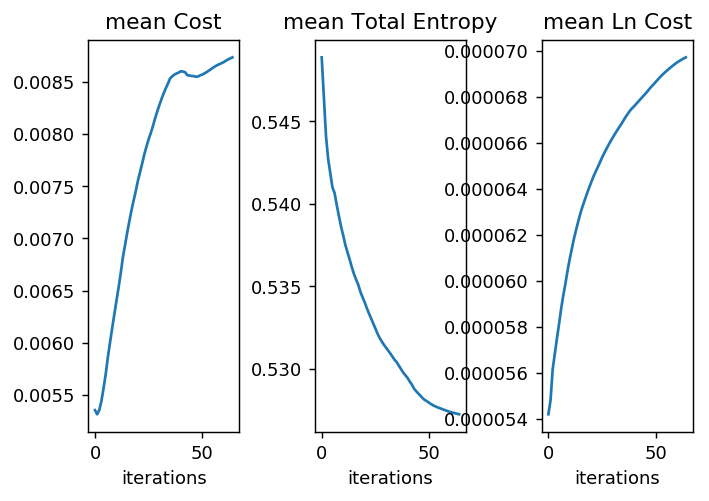

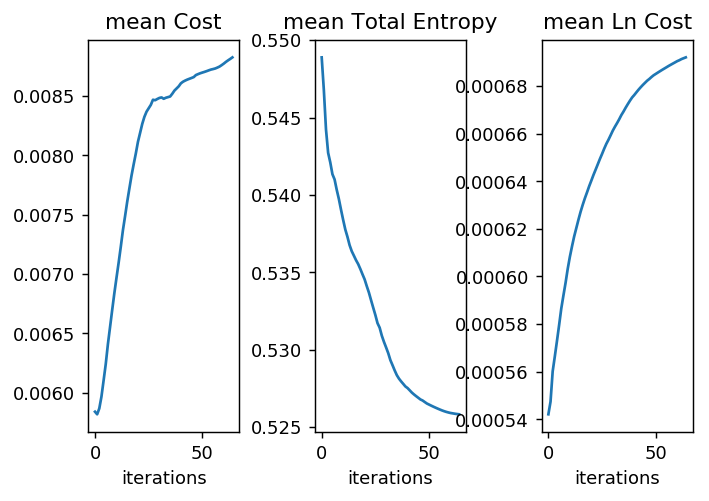

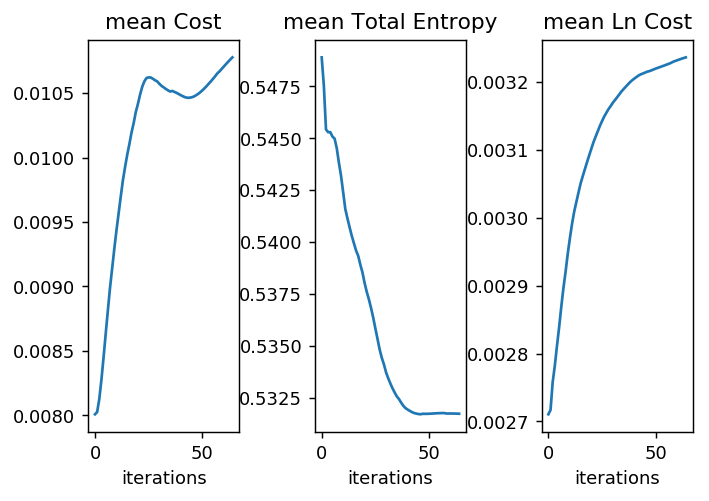

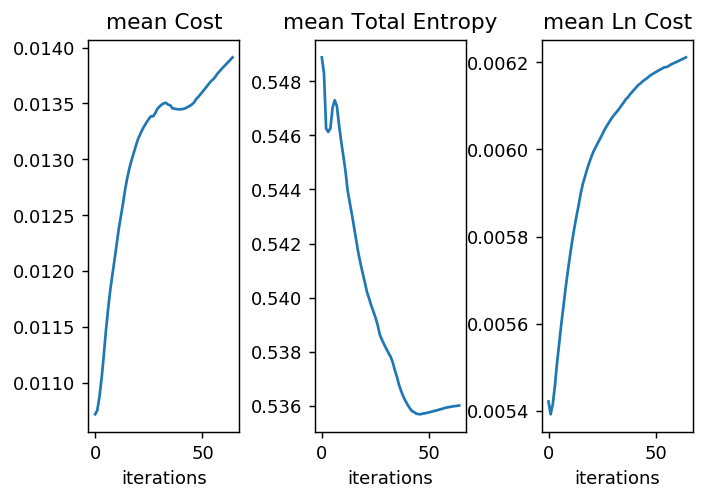

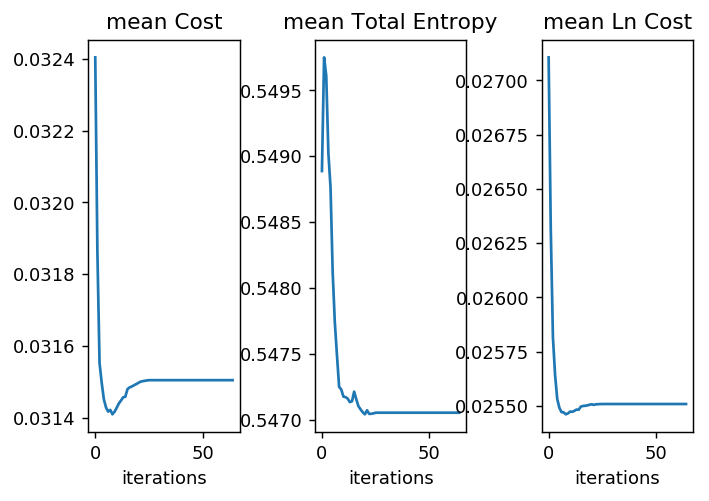

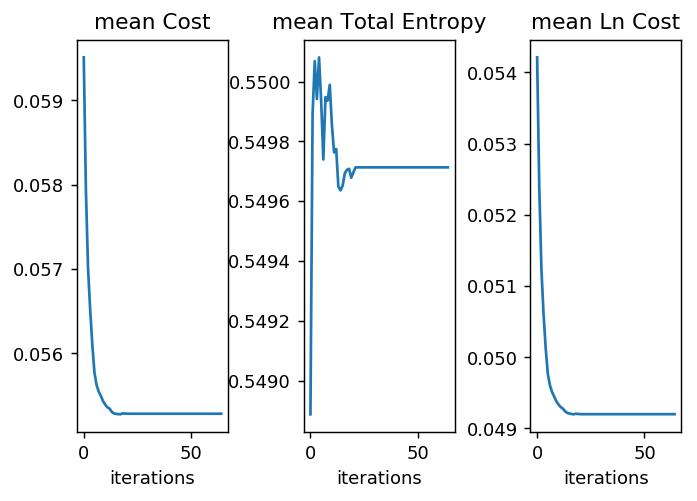

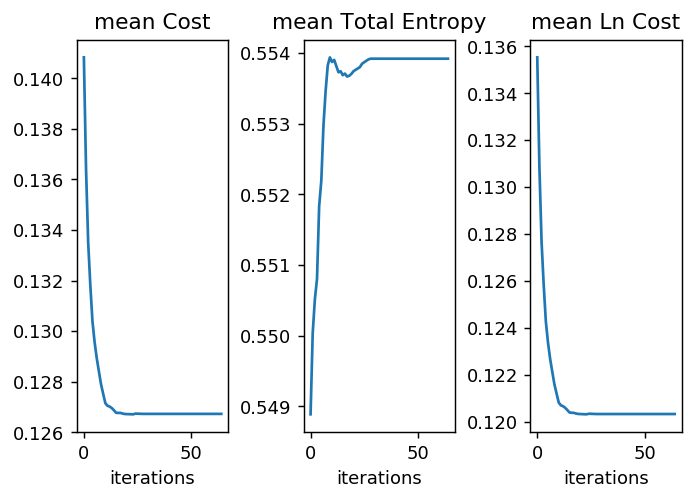

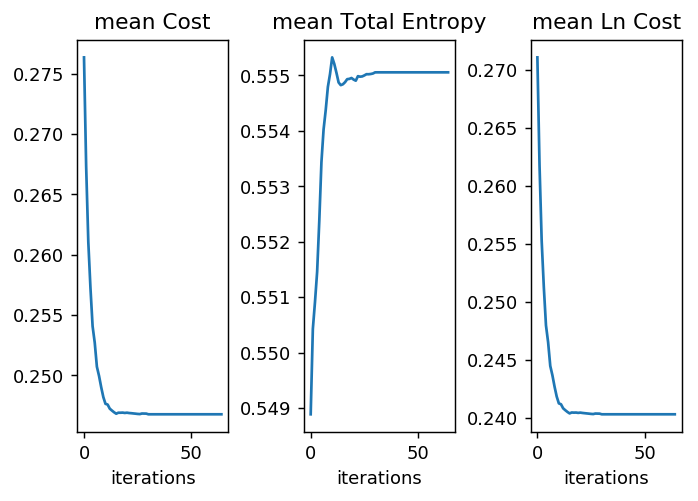

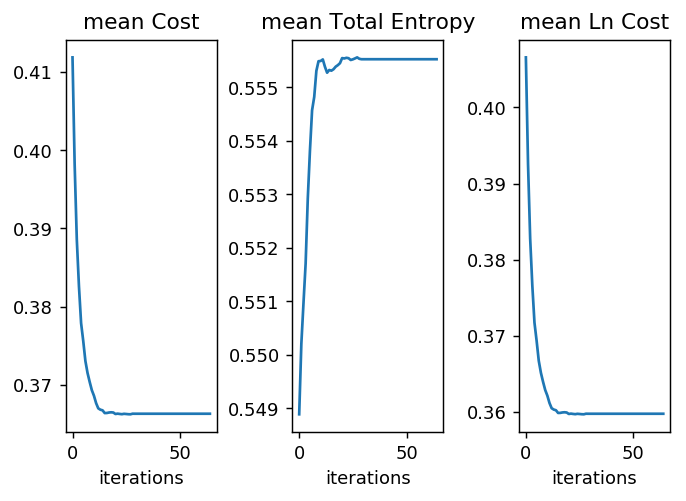

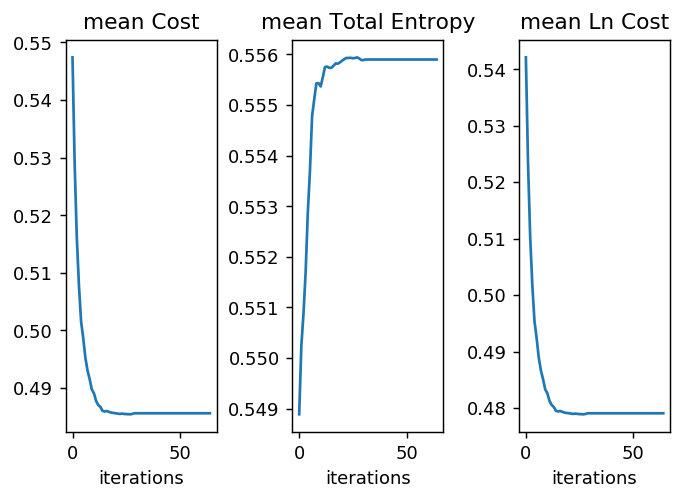

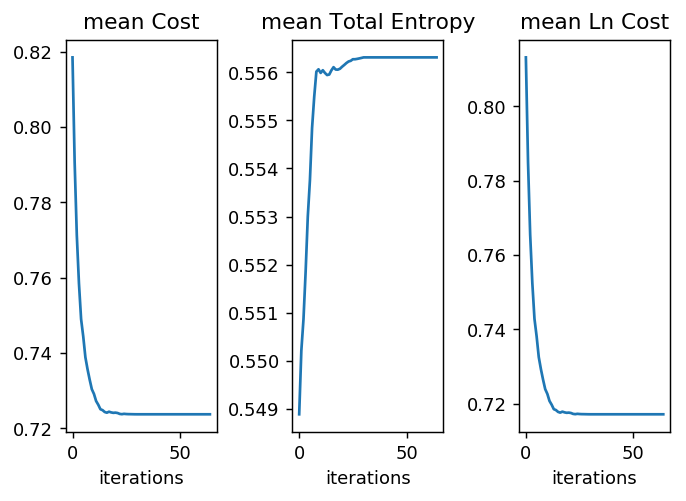

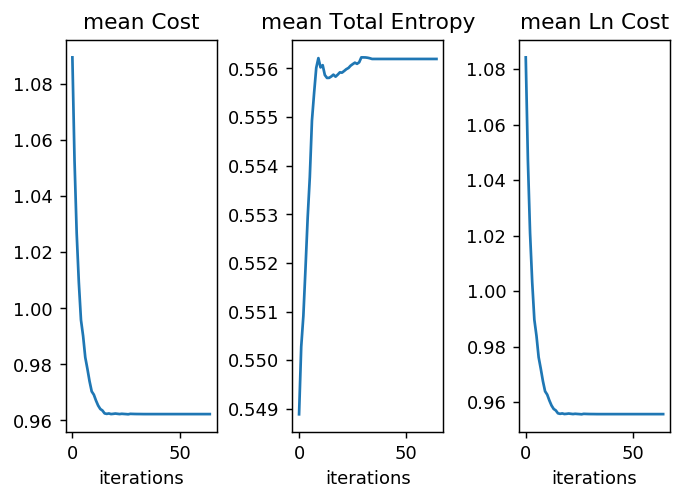

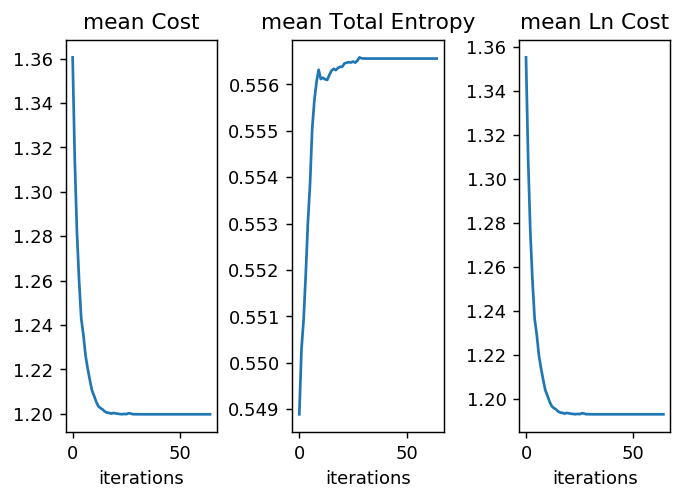

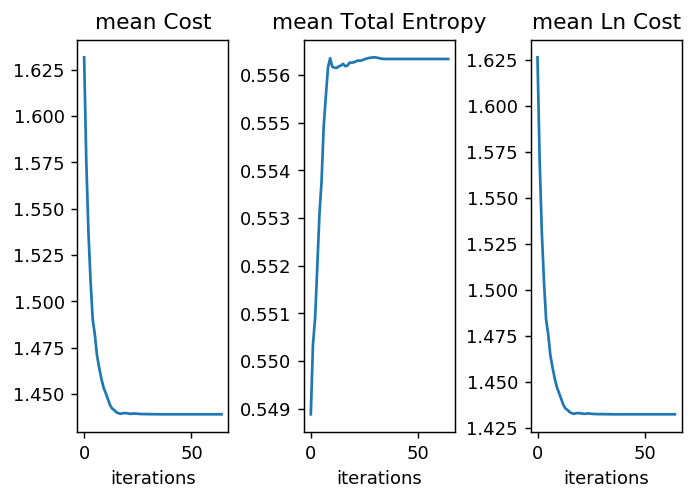

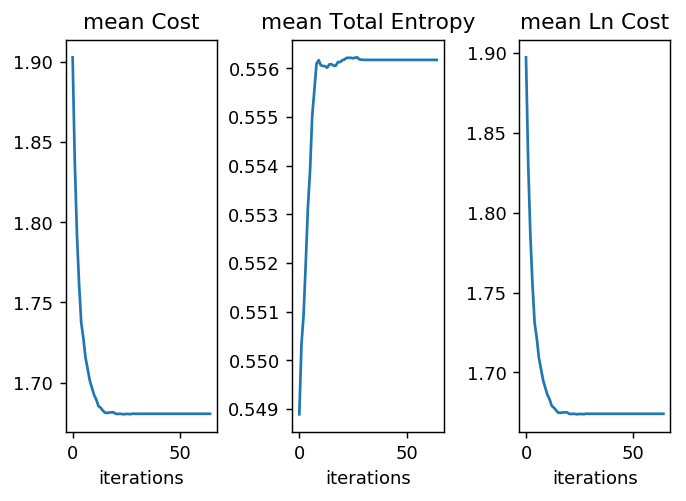

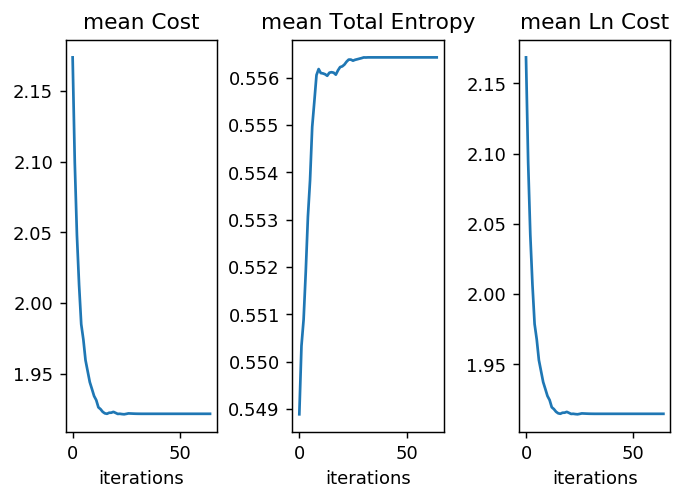

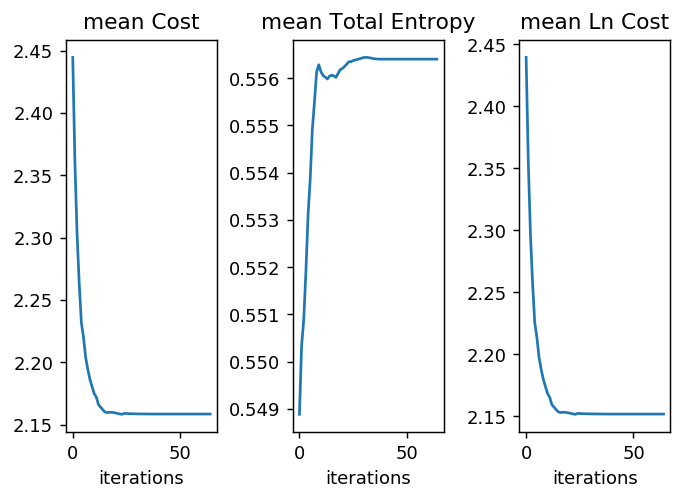

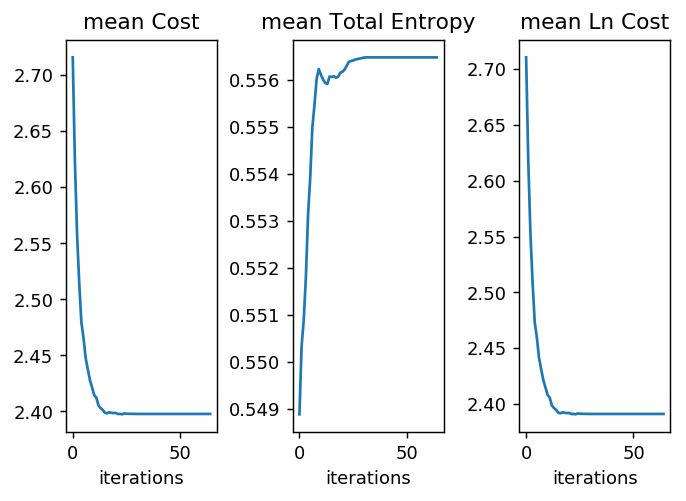

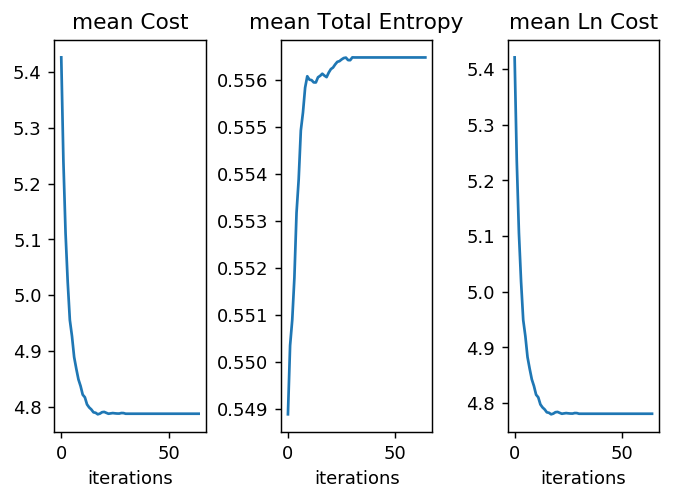

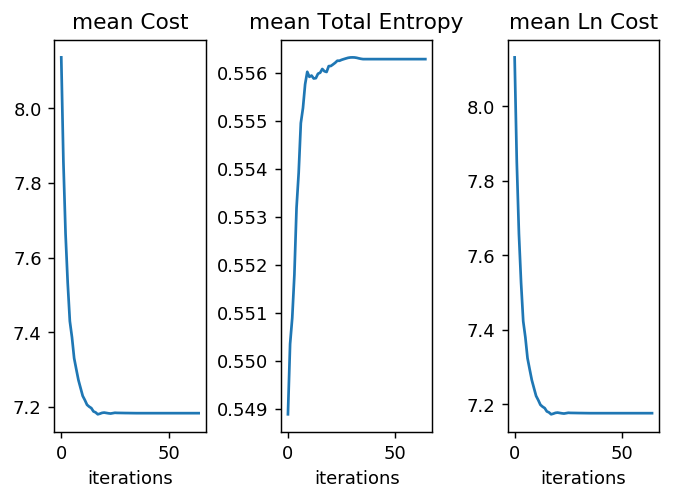

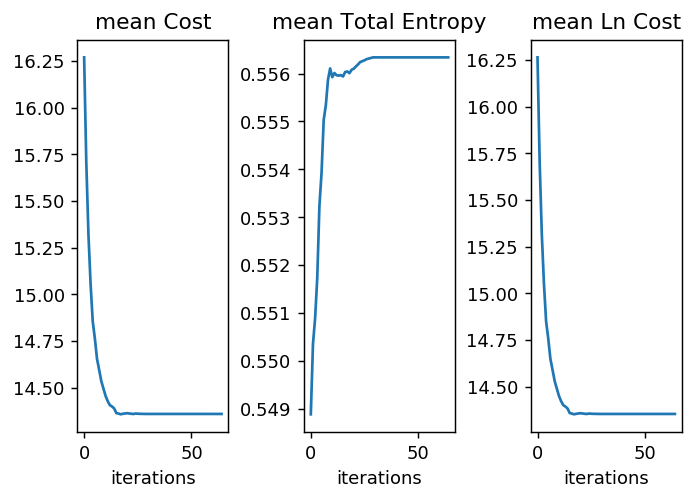

In [32]:
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch_e.reshape(x_init_batch_e.shape[0], -1).shape[1]

lr = CLUE_lr_dic_e[dname]

aleatoric_weight = 0
epistemic_weight = 1
uncertainty_weight = 0

CLUE_epistemic_delta_err_vec = []
CLUE_epistemic_delta_X_vec = []
CLUE_epistemic_logpx_vec = []


for distance_weight in (CLUE_lambdas / x_dim):
    prediction_similarity_weight = 0


    CLUE_explainer = CLUE(VAE_art, art_BNN, x_init_batch_e, uncertainty_weight=uncertainty_weight, aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                          prior_weight=0, distance_weight=distance_weight,
                     latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                     lr=lr, desired_preds=None, cond_mask=None, distance_metric=dist,
                     z_init=z_init_batch_e, norm_MNIST=False,
                     flatten_BNN=False, regression=regression_bools[names.index(dname)], cuda=True)

    torch.autograd.set_detect_anomaly(False)

    # clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
    z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
                                            min_steps=3, max_steps=65,
                                            n_early_stop=3)

    fig, axes = plt.subplots(1, 3, dpi=130)
    axes[0].plot(cost_vec.mean(axis=1))
    axes[0].set_title('mean Cost')
    axes[0].set_xlabel('iterations')

    axes[1].plot(uncertainty_vec.mean(axis=1))
    axes[1].set_title('mean Total Entropy')
    axes[1].set_xlabel('iterations')

    axes[2].plot(dist_vec.mean(axis=1))
    axes[2].set_title('mean Ln Cost')
    axes[2].set_xlabel('iterations')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    x_CLUE_epistemic = x_vec[-1]
    
    ############################################################################
    
    from interpret.functionally_grounded import evaluate_epistemic_explanation_cat, evaluate_epistemic_explanation_gauss

    total_uncert_BNN_CLUE_epistemic, aleatoric_uncert_BNN_CLUE_epistemic, epistemic_uncert_BNN_CLUE_epistemic\
            = get_BNN_uncertainties(art_BNN, x_CLUE_epistemic,
                                       regression=regression_bools[names.index(dname)], batch_size=1024,
                                       norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)


    if regression_bools[names.index(dname)]:
        CLUE_test_err, CLUE_abs_diffs = evaluate_epistemic_explanation_gauss(art_BNN, VAEAC, torch.Tensor(x_CLUE_epistemic).cuda(), test_dims=test_dims[d_idx],
                                                                           pred_sig=(not gauss_cat_vae_bools[d_idx]), outer_batch_size=2000,
                                                                           inner_batch_size=1024, VAEAC_samples=500)
    else:
        CLUE_test_err, CLUE_loglike_vec = evaluate_epistemic_explanation_cat(art_BNN, VAEAC, torch.Tensor(x_CLUE_epistemic).cuda(),
                                                                     test_dims=test_dims[d_idx], outer_batch_size=2000,
                                                                     inner_batch_size=1024, VAEAC_samples=500)


    print('original+ CLUE_epistemic mean BNN epistemic', epistemic_stack.cpu().numpy()[epistemic_idxs].mean(),\
          epistemic_uncert_BNN_CLUE_epistemic.mean())

    print('original+ CLUE_epistemic mean BNN error', GT_test_err, CLUE_test_err)

    if regression_bools[names.index(dname)]:
        print('original+ CLUE_epistemic BNN other err', CLUE_abs_diffs.mean())
    else:
        print('original+ CLUE_epistemic loglike', CLUE_loglike_vec.mean())


    CLUE_epistemic_deltax = np.abs(x_init_batch_e - x_CLUE_epistemic).sum(axis=1)
    CLUE_epistemic_fm = (GT_test_err - CLUE_test_err) / (CLUE_epistemic_deltax + 1e-6)
    print('test CLUE_epistemic fm mean std (epistemic)', np.nanmean(CLUE_epistemic_fm), np.nanstd(CLUE_epistemic_fm))

    ###########################################################

    
    if gauss_cat_vae_bools[names.index(dname)]:
        # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. Maybe for unflattened?
        log_px_vaeac_CLUE_epistemic = get_VAEAC_px_gauss_cat(under_VAEAC_net, x_CLUE_epistemic, input_dim_vec=input_dim_vec_xy,
                                              y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
    else:
        log_px_vaeac_CLUE_epistemic = get_VAEAC_px(under_VAEAC_net, x_CLUE_epistemic,
                                                   y_dims=test_dims[d_idx], Nsamples=1000)

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('original+ epistemic log_px [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_CLUE_epistemic.mean(), log_px_vaeac_CLUE_epistemic.std())

    
    CLUE_epistemic_delta_err_vec.append((GT_test_err - CLUE_test_err))
    CLUE_epistemic_delta_X_vec.append(CLUE_epistemic_deltax)
    CLUE_epistemic_logpx_vec.append(log_px_vaeac_CLUE_epistemic.data.cpu().numpy())
    
CLUE_epistemic_delta_err_vec = np.stack(CLUE_epistemic_delta_err_vec, axis=0)
CLUE_epistemic_delta_X_vec = np.stack(CLUE_epistemic_delta_X_vec, axis=0)
CLUE_epistemic_logpx_vec = np.stack(CLUE_epistemic_logpx_vec, axis=0)

## U-FIDO

In [36]:


fido_lambdas = np.logspace(np.log(0.00001), np.log(100), 30, base=np.e)



### Run FIDO aleatoric

In [37]:
from interpret.FIDO import mask_explainer

batch_size = 3000


FIDO_aleatoric_delta_H_vec = []
FIDO_aleatoric_delta_X_vec = []
FIDO_aleatoric_logpx_vec = []
for L1w in fido_lambdas:

    FIDO_explanations = []
    FIDO_masks = []
    
    aleatoric_coeff = 1
    epistemic_coeff = 0

    aux_loader = generate_ind_batch(x_init_batch_a.shape[0], batch_size, random=False, roundup=True)
    for idxs in aux_loader:

        explainer, loss_vec, aleatoric_vec, epistemic_vec = \
                mask_explainer.train_mask(torch.Tensor(x_init_batch_a[idxs]), art_BNN, VAEAC_art, aleatoric_coeff=aleatoric_coeff,
                                          epistemic_coeff=epistemic_coeff, L1w=L1w, N_epochs=30,
                              mask_samples=20, mask_samples2=10, flatten_ims=False,
                                          test_dims=None, cat=(not regression_bools[names.index(dname)])) 

        explanation, mask = explainer.mask_inpaint(torch.Tensor(x_init_batch_a[idxs]), VAEAC_art,
                                                   flatten_ims=False, test_dims=None,
                                                   cat=(not regression_bools[names.index(dname)]))

        FIDO_explanations.append(explanation)
        FIDO_masks.append(mask)

    FIDO_explanations = torch.cat(FIDO_explanations, dim=0).data.cpu()
    FIDO_masks = torch.cat(FIDO_masks, dim=0).data.cpu()

    print(FIDO_explanations.shape)

    explainer = None
    torch.cuda.empty_cache()

    x_FIDO_aleatoric  = FIDO_explanations.numpy()

    ###############################################

    from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_cat, evaluate_aleatoric_explanation_gauss

    total_uncert_BNN_FIDO_aleatoric, aleatoric_uncert_BNN_FIDO_aleatoric, epistemic_uncert_BNN_FIDO_aleatoric\
            = get_BNN_uncertainties(art_BNN, x_FIDO_aleatoric,
           regression=regression_bools[names.index(dname)], batch_size=1024,
           norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)

    if regression_bools[names.index(dname)]:
        FIDO_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_gauss(\
                                                         VAEAC, torch.Tensor(x_FIDO_aleatoric), test_dims[d_idx],
                                                          pred_sig=(not gauss_cat_vae_bools[d_idx]),
                                                                 N_target_samples=500, batch_size=1024)
    else:
        FIDO_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_cat(VAEAC, torch.Tensor(x_FIDO_aleatoric),
                                                                     test_dims[d_idx],
                                                                  N_target_samples=500, batch_size=1024)



    # np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
    print('original+ FIDO_aleatoric BNN aleatoric uncert', aleatoric_stack.cpu().numpy()[aleatoric_idxs].mean(),
                              aleatoric_uncert_BNN_FIDO_aleatoric.data.cpu().numpy().mean(axis=0))


    print('original+ test FIDO_aleatoric marginal shape', FIDO_VAEAC_aleatoric_uncert.shape)
    print('original+ test FIDO_aleatoric mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean(), FIDO_VAEAC_aleatoric_uncert.mean())


    FIDO_aleatoric_deltax = np.abs(x_init_batch_a - x_FIDO_aleatoric).sum(axis=1)
    FIDO_aleatoric_deltaH = (OG_VAEAC_aleatoric_uncert - FIDO_VAEAC_aleatoric_uncert).cpu().numpy()
    FIDO_aleatoric_fm = (OG_VAEAC_aleatoric_uncert - FIDO_VAEAC_aleatoric_uncert).cpu().numpy() / (FIDO_aleatoric_deltax + 1e-6)
    print('test FIDO_aleatoric fm mean std (aleatoric)', np.nanmean(FIDO_aleatoric_fm), np.nanstd(FIDO_aleatoric_fm))

    #############################################################
    
    from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat

    # We give complete input dim vec so that the GT VAEAC can do its thing
    # Why is override y dims not implemented by using test_dims? -> because it unites categoricals

    if gauss_cat_vae_bools[names.index(dname)]:
        # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. Maybe for unflattened?
        log_px_vaeac_FIDO_aleatoric = get_VAEAC_px_gauss_cat(under_VAEAC_net, x_FIDO_aleatoric, input_dim_vec=input_dim_vec_xy,
                                              y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
    else:
        log_px_vaeac_FIDO_aleatoric = get_VAEAC_px(under_VAEAC_net, x_FIDO_aleatoric, y_dims=test_dims[d_idx], Nsamples=10000)

    print('original+ FIDO_aleatoric log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_FIDO_aleatoric.mean(), log_px_vaeac_FIDO_aleatoric.std())

    
    FIDO_aleatoric_delta_H_vec.append(FIDO_aleatoric_deltaH)
    FIDO_aleatoric_delta_X_vec.append(FIDO_aleatoric_deltax)
    FIDO_aleatoric_logpx_vec.append(log_px_vaeac_FIDO_aleatoric.data.cpu().numpy())
    
FIDO_aleatoric_delta_H_vec = np.stack(FIDO_aleatoric_delta_H_vec, axis=0)
FIDO_aleatoric_delta_X_vec = np.stack(FIDO_aleatoric_delta_X_vec, axis=0)
FIDO_aleatoric_logpx_vec = np.stack(FIDO_aleatoric_logpx_vec, axis=0)
    



Net:
it: 0, loss: 0.485, aleatoric: 0.485, epistemic: 0.069
it: 1, loss: 0.478, aleatoric: 0.478, epistemic: 0.068
it: 2, loss: 0.471, aleatoric: 0.471, epistemic: 0.067
it: 3, loss: 0.464, aleatoric: 0.464, epistemic: 0.066
it: 4, loss: 0.458, aleatoric: 0.457, epistemic: 0.065
it: 5, loss: 0.449, aleatoric: 0.449, epistemic: 0.063
it: 6, loss: 0.443, aleatoric: 0.443, epistemic: 0.062
it: 7, loss: 0.437, aleatoric: 0.437, epistemic: 0.061
it: 8, loss: 0.431, aleatoric: 0.431, epistemic: 0.060
it: 9, loss: 0.425, aleatoric: 0.425, epistemic: 0.059
it: 10, loss: 0.418, aleatoric: 0.418, epistemic: 0.058
it: 11, loss: 0.412, aleatoric: 0.412, epistemic: 0.057
it: 12, loss: 0.407, aleatoric: 0.407, epistemic: 0.056
it: 13, loss: 0.401, aleatoric: 0.401, epistemic: 0.055
it: 14, loss: 0.397, aleatoric: 0.397, epistemic: 0.054
it: 15, loss: 0.392, aleatoric: 0.392, epistemic: 0.054
it: 16, loss: 0.390, aleatoric: 0.390, epistemic: 0.053
it: 17, loss: 0.389, aleatoric: 0.389, epistemic: 0.

('original+ FIDO_aleatoric BNN aleatoric uncert', 0.5533387, 0.5222473)
('original+ test FIDO_aleatoric marginal shape', torch.Size([1384]))
('original+ test FIDO_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.5213))
('test FIDO_aleatoric fm mean std (aleatoric)', 0.0049297735, 0.02312618)
('original+ FIDO_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-44.2310, device='cuda:0'), tensor(89.8337, device='cuda:0'))

Net:
it: 0, loss: 0.490, aleatoric: 0.485, epistemic: 0.069
it: 1, loss: 0.484, aleatoric: 0.479, epistemic: 0.068
it: 2, loss: 0.477, aleatoric: 0.472, epistemic: 0.067
it: 3, loss: 0.470, aleatoric: 0.466, epistemic: 0.066
it: 4, loss: 0.462, aleatoric: 0.458, epistemic: 0.065
it: 5, loss: 0.455, aleatoric: 0.451, epistemic: 0.064
it: 6, loss: 0.449, aleatoric: 0.445, epistemic: 0.063
it: 7, loss: 0.442, aleatoric: 0.438, epistemic: 0.062
it: 8, loss: 0.436, aleatoric: 0.432, epistemic: 0.061
it: 9, loss: 0.430, aleatoric: 0.426, epis

it: 23, loss: 0.441, aleatoric: 0.404, epistemic: 0.080
it: 24, loss: 0.440, aleatoric: 0.403, epistemic: 0.080
it: 25, loss: 0.440, aleatoric: 0.403, epistemic: 0.080
it: 26, loss: 0.440, aleatoric: 0.402, epistemic: 0.080
it: 27, loss: 0.439, aleatoric: 0.402, epistemic: 0.079
it: 28, loss: 0.439, aleatoric: 0.402, epistemic: 0.079
it: 29, loss: 0.438, aleatoric: 0.401, epistemic: 0.079
torch.Size([1384, 29])
('original+ FIDO_aleatoric BNN aleatoric uncert', 0.5533387, 0.5418275)
('original+ test FIDO_aleatoric marginal shape', torch.Size([1384]))
('original+ test FIDO_aleatoric mean uncert (aleatoric)', tensor(0.5679), tensor(0.5432))
('test FIDO_aleatoric fm mean std (aleatoric)', -232.37668, 10505.91)
('original+ FIDO_aleatoric log_px [mean, std]', tensor(-95.4752, device='cuda:0'), tensor(-81.2091, device='cuda:0'), tensor(195.7656, device='cuda:0'))

Net:
it: 0, loss: 0.985, aleatoric: 0.485, epistemic: 0.069
it: 1, loss: 0.935, aleatoric: 0.482, epistemic: 0.072
it: 2, loss: 0.

it: 15, loss: 0.482, aleatoric: 0.456, epistemic: 0.106
it: 16, loss: 0.466, aleatoric: 0.456, epistemic: 0.106
it: 17, loss: 0.459, aleatoric: 0.456, epistemic: 0.106
it: 18, loss: 0.457, aleatoric: 0.456, epistemic: 0.106
it: 19, loss: 0.457, aleatoric: 0.456, epistemic: 0.106
it: 20, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 21, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 22, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 23, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 24, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 25, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 26, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 27, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 28, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
it: 29, loss: 0.456, aleatoric: 0.456, epistemic: 0.106
torch.Size([1384, 29])
('original+ FIDO_aleatoric BNN aleatoric uncert', 0.5533387, 0.5533387)
('original+ test FIDO_aleatoric marginal shape', torch.Size([1384

### Run FIDO epistemic 

In [39]:
from interpret.FIDO import mask_explainer

batch_size = 3000

FIDO_epistemic_delta_err_vec = []
FIDO_epistemic_delta_X_vec = []
FIDO_epistemic_logpx_vec = []
for L1w in fido_lambdas:

    FIDO_explanations = []
    FIDO_masks = []

    aleatoric_coeff = 0
    epistemic_coeff = 1

    aux_loader = generate_ind_batch(x_init_batch_e.shape[0], batch_size, random=False, roundup=True)
    for idxs in aux_loader:

        explainer, loss_vec, aleatoric_vec, epistemic_vec = \
                mask_explainer.train_mask(torch.Tensor(x_init_batch_e[idxs]), art_BNN, VAEAC_art, aleatoric_coeff=aleatoric_coeff,
                                          epistemic_coeff=epistemic_coeff, L1w=L1w, N_epochs=30,
                              mask_samples=20, mask_samples2=10, flatten_ims=False,
                                          test_dims=None, cat=(not regression_bools[names.index(dname)])) 

        explanation, mask = explainer.mask_inpaint(torch.Tensor(x_init_batch_e[idxs]), VAEAC_art,
                                                   flatten_ims=False, test_dims=None,
                                                   cat=(not regression_bools[names.index(dname)]))

        FIDO_explanations.append(explanation)
        FIDO_masks.append(mask)

    FIDO_explanations = torch.cat(FIDO_explanations, dim=0).data.cpu()
    FIDO_masks = torch.cat(FIDO_masks, dim=0).data.cpu()

    print(FIDO_explanations.shape)

    explainer = None
    torch.cuda.empty_cache()

    x_FIDO_epistemic  = FIDO_explanations.numpy()

    ########################################################################
    
    from interpret.functionally_grounded import evaluate_epistemic_explanation_cat, evaluate_epistemic_explanation_gauss

    total_uncert_BNN_FIDO_epistemic, aleatoric_uncert_BNN_FIDO_epistemic, epistemic_uncert_BNN_FIDO_epistemic\
            = get_BNN_uncertainties(art_BNN, x_FIDO_epistemic,
           regression=regression_bools[names.index(dname)], batch_size=1024,
           norm_MNIST=False, flatten=False, return_probs=False, prob_BNN=True)

    if regression_bools[names.index(dname)]:
        FIDO_test_err, FIDO_abs_diffs = evaluate_epistemic_explanation_gauss(art_BNN, VAEAC,
                                         torch.Tensor(x_FIDO_epistemic).cuda(), test_dims=test_dims[d_idx],
                                       pred_sig=(not gauss_cat_vae_bools[d_idx]), outer_batch_size=2000,
                                       inner_batch_size=1024, VAEAC_samples=500)
    else:
        FIDO_test_err, FIDO_loglike_vec = evaluate_epistemic_explanation_cat(art_BNN, VAEAC,
                                                         torch.Tensor(x_FIDO_epistemic).cuda(),
                                                         test_dims=test_dims[d_idx], outer_batch_size=2000,
                                                         inner_batch_size=1024, VAEAC_samples=500)


    print('original+ FIDO_epistemic mean BNN epistemic', epistemic_stack.cpu().numpy()[epistemic_idxs].mean(),
          epistemic_uncert_BNN_FIDO_epistemic.mean())

    print('original+ FIDO_epistemic mean BNN error', GT_test_err, FIDO_test_err)

    if regression_bools[names.index(dname)]:
        print('original+ FIDO_epistemic BNN other err', FIDO_abs_diffs.mean())
    else:
        print('original+ FIDO_epistemic loglike', FIDO_loglike_vec.mean())


    FIDO_epistemic_deltax = np.abs(x_init_batch_e - x_FIDO_epistemic).sum(axis=1)
    FIDO_epistemic_fm = (GT_test_err - FIDO_test_err) / (FIDO_epistemic_deltax + 1e-6)
    print('test FIDO_epistemic fm mean std (epistemic)', np.nanmean(FIDO_epistemic_fm), np.nanstd(FIDO_epistemic_fm))


    ########################################################################


    if gauss_cat_vae_bools[names.index(dname)]:
        # override_y_dims doesnt use y_dims for likelihood calculation but instead uses :-override. Maybe for unflattened?
        log_px_vaeac_FIDO_epistemic = get_VAEAC_px_gauss_cat(under_VAEAC_net, x_FIDO_epistemic, input_dim_vec=input_dim_vec_xy,
                                              y_dims=test_dims[d_idx], override_y_dims=1, Nsamples=1000)
    else:
        log_px_vaeac_FIDO_epistemic = get_VAEAC_px(under_VAEAC_net, x_FIDO_epistemic, y_dims=test_dims[d_idx], Nsamples=10000)

    print('original+ FIDO_epistemic log_px [mean mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_FIDO_epistemic.mean(), log_px_vaeac_FIDO_epistemic.std())

    FIDO_epistemic_delta_err_vec.append((GT_test_err - FIDO_test_err))
    FIDO_epistemic_delta_X_vec.append(FIDO_epistemic_deltax)
    FIDO_epistemic_logpx_vec.append(log_px_vaeac_FIDO_epistemic.data.cpu().numpy())
    
FIDO_epistemic_delta_err_vec = np.stack(FIDO_epistemic_delta_err_vec, axis=0)
FIDO_epistemic_delta_X_vec = np.stack(FIDO_epistemic_delta_X_vec, axis=0)
FIDO_epistemic_logpx_vec = np.stack(FIDO_epistemic_logpx_vec, axis=0)



Net:
it: 0, loss: 0.081, aleatoric: 0.406, epistemic: 0.081
it: 1, loss: 0.080, aleatoric: 0.399, epistemic: 0.080
it: 2, loss: 0.080, aleatoric: 0.396, epistemic: 0.080
it: 3, loss: 0.078, aleatoric: 0.390, epistemic: 0.078
it: 4, loss: 0.078, aleatoric: 0.386, epistemic: 0.078
it: 5, loss: 0.077, aleatoric: 0.380, epistemic: 0.077
it: 6, loss: 0.076, aleatoric: 0.377, epistemic: 0.076
it: 7, loss: 0.075, aleatoric: 0.372, epistemic: 0.075
it: 8, loss: 0.074, aleatoric: 0.368, epistemic: 0.074
it: 9, loss: 0.074, aleatoric: 0.363, epistemic: 0.074
it: 10, loss: 0.073, aleatoric: 0.360, epistemic: 0.073
it: 11, loss: 0.073, aleatoric: 0.360, epistemic: 0.073
it: 12, loss: 0.071, aleatoric: 0.355, epistemic: 0.071
it: 13, loss: 0.070, aleatoric: 0.351, epistemic: 0.070
it: 14, loss: 0.070, aleatoric: 0.348, epistemic: 0.070
it: 15, loss: 0.070, aleatoric: 0.346, epistemic: 0.070
it: 16, loss: 0.069, aleatoric: 0.343, epistemic: 0.069
it: 17, loss: 0.069, aleatoric: 0.343, epistemic: 0.

('original+ FIDO_epistemic log_px [mean mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-82.9584, device='cuda:0'), tensor(140.6228, device='cuda:0'))

Net:
it: 0, loss: 0.086, aleatoric: 0.404, epistemic: 0.081
it: 1, loss: 0.085, aleatoric: 0.398, epistemic: 0.080
it: 2, loss: 0.085, aleatoric: 0.395, epistemic: 0.080
it: 3, loss: 0.084, aleatoric: 0.389, epistemic: 0.079
it: 4, loss: 0.083, aleatoric: 0.384, epistemic: 0.078
it: 5, loss: 0.082, aleatoric: 0.381, epistemic: 0.078
it: 6, loss: 0.081, aleatoric: 0.375, epistemic: 0.077
it: 7, loss: 0.081, aleatoric: 0.370, epistemic: 0.076
it: 8, loss: 0.080, aleatoric: 0.365, epistemic: 0.076
it: 9, loss: 0.079, aleatoric: 0.362, epistemic: 0.075
it: 10, loss: 0.078, aleatoric: 0.359, epistemic: 0.075
it: 11, loss: 0.077, aleatoric: 0.351, epistemic: 0.074
it: 12, loss: 0.078, aleatoric: 0.351, epistemic: 0.074
it: 13, loss: 0.077, aleatoric: 0.350, epistemic: 0.074
it: 14, loss: 0.076, aleatoric: 0.345, epistemic: 0.072
it: 1

it: 28, loss: 0.116, aleatoric: 0.332, epistemic: 0.109
it: 29, loss: 0.116, aleatoric: 0.331, epistemic: 0.109
torch.Size([655, 29])
('original+ FIDO_epistemic mean BNN epistemic', 0.012351, tensor(0.0117, device='cuda:0'))
('original+ FIDO_epistemic mean BNN error', 0.516030534351145, 0.5053435114503817)
('original+ FIDO_epistemic loglike', -0.7796973)
('test FIDO_epistemic fm mean std (epistemic)', 7864.345, 4711.528)
('original+ FIDO_epistemic log_px [mean mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-111.3187, device='cuda:0'), tensor(277.4678, device='cuda:0'))

Net:
it: 0, loss: 0.582, aleatoric: 0.405, epistemic: 0.081
it: 1, loss: 0.536, aleatoric: 0.396, epistemic: 0.085
it: 2, loss: 0.493, aleatoric: 0.389, epistemic: 0.089
it: 3, loss: 0.452, aleatoric: 0.383, epistemic: 0.093
it: 4, loss: 0.409, aleatoric: 0.378, epistemic: 0.096
it: 5, loss: 0.368, aleatoric: 0.370, epistemic: 0.099
it: 6, loss: 0.335, aleatoric: 0.366, epistemic: 0.101
it: 7, loss: 0.302, alea

it: 21, loss: 0.119, aleatoric: 0.340, epistemic: 0.118
it: 22, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 23, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 24, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 25, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 26, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 27, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 28, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
it: 29, loss: 0.118, aleatoric: 0.340, epistemic: 0.118
torch.Size([655, 29])
('original+ FIDO_epistemic mean BNN epistemic', 0.012351, tensor(0.0124, device='cuda:0'))
('original+ FIDO_epistemic mean BNN error', 0.516030534351145, 0.5145038167938931)
('original+ FIDO_epistemic loglike', -0.7957519)
('test FIDO_epistemic fm mean std (epistemic)', 1526.7178, 0.00024414062)
('original+ FIDO_epistemic log_px [mean mean, std]', tensor(-110.5760, device='cuda:0'), tensor(-111.0143, device='cuda:0'), tensor(278.7965, device='cuda:0'))

Net:
it: 0, loss

In [48]:
def find_extrema(array_list, use_max=True):
    
    joint = np.concatenate(array_list, axis=0)
    if use_max:
        return joint.max()
    else:
        return joint.min()
    

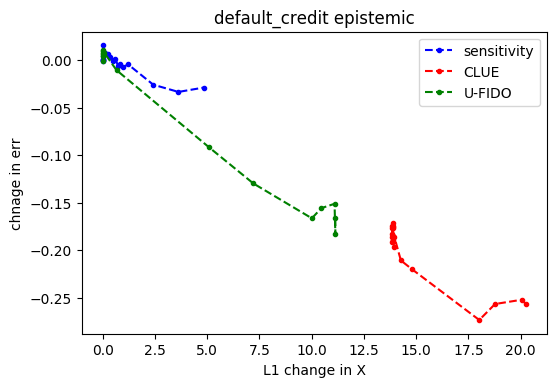

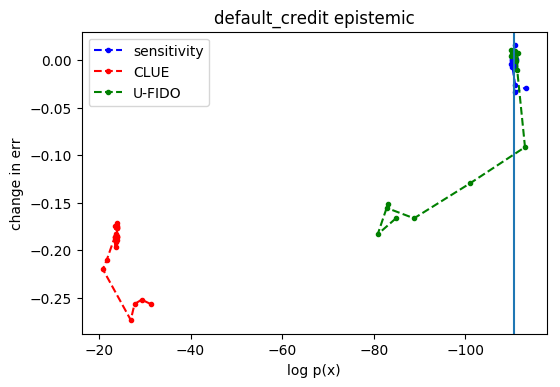

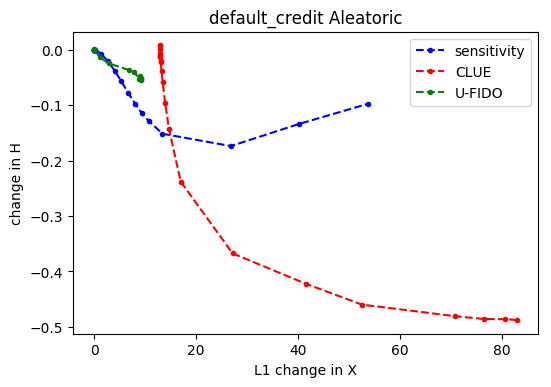

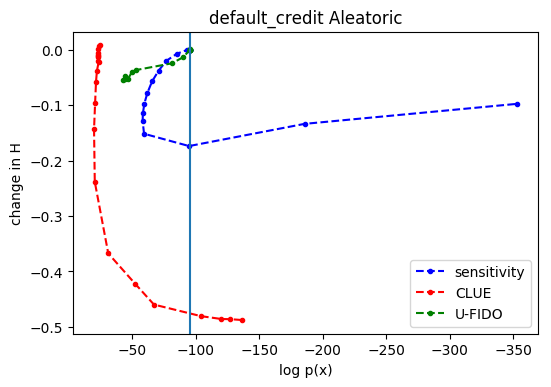

In [49]:

plt.figure(dpi=100)
plt.plot(sense_epistemic_delta_X_vec.mean(axis=1), -sense_epistemic_delta_err_vec, '--.', c='b')
plt.plot(CLUE_epistemic_delta_X_vec.mean(axis=1), -CLUE_epistemic_delta_err_vec, '--.', c='r')
plt.plot(FIDO_epistemic_delta_X_vec.mean(axis=1), -FIDO_epistemic_delta_err_vec, '--.', c='g')
plt.title(dname + ' epistemic')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('L1 change in X')
plt.ylabel('chnage in err')
# plt.ylim([-0.1, 0.3])
# plt.xlim([0, 10])
# ax = plt.gca()
# ax.invert_xaxis()

plt.figure(dpi=100)
plt.plot(sense_epistemic_logpx_vec.mean(axis=1), -sense_epistemic_delta_err_vec, '--.', c='b')
plt.plot(CLUE_epistemic_logpx_vec.mean(axis=1), -CLUE_epistemic_delta_err_vec, '--.', c='r')
plt.plot(FIDO_epistemic_logpx_vec.mean(axis=1), -FIDO_epistemic_delta_err_vec, '--.', c='g')
ax = plt.gca()
ax.axvline(x=log_px_vaeac_e.mean())
plt.title(dname + ' epistemic')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('log p(x)')
plt.ylabel('change in err')
# plt.ylim([-0.1, 0.3])
# plt.xlim([log_px_vaeac_e.mean().item()-20, log_px_vaeac_e.mean().item()+5])
ax.invert_xaxis()


plt.figure(dpi=100)
plt.plot(sense_aleatoric_delta_X_vec.mean(axis=1), -sense_aleatoric_delta_H_vec.mean(axis=1), '--.', c='b')
plt.plot(CLUE_aleatoric_delta_X_vec.mean(axis=1), -CLUE_aleatoric_delta_H_vec.mean(axis=1), '--.', c='r')
plt.plot(FIDO_aleatoric_delta_X_vec.mean(axis=1), -FIDO_aleatoric_delta_H_vec.mean(axis=1), '--.', c='g')
plt.title(dname + ' Aleatoric')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('L1 change in X')
plt.ylabel('change in H')
# plt.ylim([-0.1, 0.3])
# plt.xlim([0, 10])
# ax = plt.gca()
# ax.invert_xaxis()

plt.figure(dpi=100)
plt.plot(sense_aleatoric_logpx_vec.mean(axis=1), -sense_aleatoric_delta_H_vec.mean(axis=1), '--.', c='b')
plt.plot(CLUE_aleatoric_logpx_vec.mean(axis=1), -CLUE_aleatoric_delta_H_vec.mean(axis=1), '--.', c='r')
plt.plot(FIDO_aleatoric_logpx_vec.mean(axis=1), -FIDO_aleatoric_delta_H_vec.mean(axis=1), '--.', c='g')
ax = plt.gca()
ax.axvline(x=log_px_vaeac_a.mean())

plt.title(dname + ' Aleatoric')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('log p(x)')
plt.ylabel('change in H')
# plt.xlim([log_px_vaeac_a.mean().item()-20, log_px_vaeac_a.mean().item()+5])
# plt.ylim([-0.1, 0.3])
ax.invert_xaxis()
# plt.ylim([-0.1, 0.3])